<a href="https://colab.research.google.com/github/Theresa20191/Theresa/blob/main/UTM/Lab%20Exercise/Lab_2B_Big_Data_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis of 7+ million company dataset

## Objective

* What can we learn about business names?
* How can we use these insights?

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install geotext

In [3]:
pip install -U kaleido

In [15]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geotext
import collections
import string, sys, os, re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import Image
from functools import reduce
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
warnings.filterwarnings('ignore')

## Helper functions and classes

In [38]:
class DfOverview:
    """
        Give an overview for a given data frame,
        like null persentage for each columns,
        unique value percentage for each columns and more
    """

    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df

    def missing_value(self) -> None:
        nullSum = self.df.isna().sum()
        return [col for col in nullSum]

    def percentage(self, list):
        return [str(round(((value / self.df.shape[0]) * 100), 2)) + '%' for value in list]

    def getOverview(self) -> None:

        _columns = [column for column in self.df]
        _count = self.df.count().values
        _unique = [self.df[column].value_counts().shape[0] for column in self.df]
        _missing_values = self.missing_value()

        columns = [
            'Column',
            'count',
            'missing_value_count',
            'Missing_value_percentage',
            'unique_value_count',
            'unique_value_percentage',
            'dtype']
        data = zip(
            _columns,
            _count,
            _missing_values,
            self.percentage(_missing_values),
            _unique,
            self.percentage(_unique),
            self.df.dtypes
        )
        new_df = pd.DataFrame(data=data, columns=columns)
        return new_df

In [39]:
def show_cols_mixed_dtypes(df):
    mixed_dtypes = {'Column': [], 'Data type': []}
    for col in df.columns:
        dtype = pd.api.types.infer_dtype(df[col])
        if dtype.startswith("mixed"):
            mixed_dtypes['Column'].append(col)
            mixed_dtypes['Data type'].append(dtype)
    if len(mixed_dtypes['Column']) == 0:
        print('None of the columns contain mixed types.')
    else:
        print(pd.DataFrame(mixed_dtypes))

In [40]:
def percent_missing_values(df):

    # Calculate total number of cells in dataframe
    totalCells = np.product(df.shape)

    # Count number of missing values per column
    missingCount = df.isnull().sum()

    # Calculate total number of missing values
    totalMissing = missingCount.sum()

    # Calculate percentage of missing values
    print("The dataset contains", round(((totalMissing/totalCells) * 100), 2), "%", "missing values.")

In [31]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * mis_val / len(df)

    # dtype of missing values
    mis_val_dtype = df.dtypes

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_dtype], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'Dtype'})

    # Sort the table by percentage of missing descending and remove columns with no missing values
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,0] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    if mis_val_table_ren_columns.shape[0] == 0:
        return

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [32]:
def convert_to_string(df, columns):
    for col in columns:
        df[col] = df[col].astype("string")

In [14]:
def drop_duplicates(df):
    old = df.shape[0]
    df.drop_duplicates(inplace=True)
    new = df.shape[0]
    count = old - new
    if (count == 0):
        print("No duplicate rows were found.")
    else:
        print(f"{count} duplicate rows were found and removed.")

def plot_dist(df:pd.DataFrame, column:str, color:str='cornflowerblue')->None:
    sns.displot(data=df, x=column, color=color,  kde=False, height=6, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

def plotly_plot_bar(df, x, y, title=None, width=800, color=['cornflowerblue']):
    if title == None:
        title=f'Distribution of {x}'
    fig = px.bar(df, x=x, y=y, title=title)
    return Image(pio.to_image(fig, format='png', width=width))

def plotly_plot_pie(df, column, title=None, width=800, limit=None):
    a = pd.DataFrame({'count': df.groupby([column]).size()}).reset_index()
    a = a.sort_values("count", ascending=False)
    if limit:
        a.loc[a['count'] < limit, column] = f'Other {column}s'
    if title == None:
        title=f'Distribution of {column}'
    fig = px.pie(a, values='count', names=column, title=title)
    return Image(pio.to_image(fig, format='png', width=width))

## Data Reading

In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assessment_EDA/companies_sorted.csv')
df

Unnamed: 0                            name  \
0           5872184                             ibm   
1           4425416       tata consultancy services   
2             21074                       accenture   
3           2309813                         us army   
4           1558607                              ey   
...             ...                             ...   
7173421     1494427              certiport vouchers   
7173422     1494429          black tiger fight club   
7173423     4768462      catholic bishop of chicago   
7173424     1494436             medexo robotics ltd   
7173425     2842728  dynamic controls solutions inc   

                               domain  year founded  \
0                             ibm.com        1911.0   
1                             tcs.com        1968.0   
2                       accenture.com        1989.0   
3                          goarmy.com        1800.0   
4                              ey.com        1989.0   
...                               ...           ...   
7173421         certiportvouchers.com        2011.0   
7173422            blacktigerclub.com        2006.0   
7173423                           NaN           NaN   
7173424                           NaN           NaN   
7173425  dynamiccontrolssolutions.com           NaN   

                                    industry size range  \
0        information technology and services     10001+   
1        information technology and services     10001+   
2        information technology and services     10001+   
3                                   military     10001+   
4                                 accounting     10001+   
...                                      ...        ...   
7173421  information technology and services     1 - 10   
7173422         health, wellness and fitness     1 - 10   
7173423               religious institutions     1 - 10   
7173424                             research     1 - 10   
7173425                           automotive     1 - 10   

                                       locality         country  \
0             new york, new york, united states   united states   
1                    bombay, maharashtra, india           india   
2                       dublin, dublin, ireland         ireland   
3           alexandria, virginia, united states   united states   
4        london, greater london, united kingdom  united kingdom   
...                                         ...             ...   
7173421                                     NaN             NaN   
7173422                  peking, beijing, china           china   
7173423      inverness, illinois, united states   united states   
7173424          london, london, united kingdom  united kingdom   
7173425          wixom, michigan, united states   united states   

                                              linkedin url  \
0                                 linkedin.com/company/ibm   
1           linkedin.com/company/tata-consultancy-services   
2                           linkedin.com/company/accenture   
3                             linkedin.com/company/us-army   
4                       linkedin.com/company/ernstandyoung   
...                                                    ...   
7173421            linkedin.com/company/certiport-vouchers   
7173422         linkedin.com/company/black-tiger-club-hero   
7173423    linkedin.com/company/catholic-bishop-of-chicago   
7173424           linkedin.com/company/medexo-robotics-ltd   
7173425  linkedin.com/company/dynamic-controls-solution...   

         current employee estimate  total employee estimate  
0                           274047                   716906  
1                           190771                   341369  
2                           190689                   455768  
3                           162163                   445958  
4                           158363                   428960  
...                            ...                      

## General Statistics

In [12]:
# number of elements(cells) in the df
df.size

78907686

In [13]:
# rows and columns in the df
df.shape

(7173426, 11)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7173426 entries, 0 to 7173425
Data columns (total 11 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0                 int64  
 1   name                       object 
 2   domain                     object 
 3   year founded               float64
 4   industry                   object 
 5   size range                 object 
 6   locality                   object 
 7   country                    object 
 8   linkedin url               object 
 9   current employee estimate  int64  
 10  total employee estimate    int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 602.0+ MB


In [15]:
df_overview = DfOverview(df)
df_overview.getOverview()

Column    count  missing_value_count  \
0                  Unnamed: 0  7173426                    0   
1                        name  7173423                    3   
2                      domain  5522805              1650621   
3                year founded  3566446              3606980   
4                    industry  6883423               290003   
5                  size range  7173426                    0   
6                    locality  4664601              2508825   
7                     country  4824219              2349207   
8                linkedin url  7173426                    0   
9   current employee estimate  7173426                    0   
10    total employee estimate  7173426                    0   

   Missing_value_percentage  unique_value_count unique_value_percentage  \
0                      0.0%             7173426                  100.0%   
1                      0.0%             7004634                  97.65%   
2                    23.01%             5474764                  76.32%   
3                    50.28%                 234                    0.0%   
4                     4.04%                 148                    0.0%   
5                      0.0%                   8                    0.0%   
6                    34.97%               96244                   1.34%   
7                    32.75%                 236                    0.0%   
8                      0.0%             7173426                  100.0%   
9                      0.0%                5379                   0.07%   
10                     0.0%                8486                   0.12%   

      dtype  
0     int64  
1    object  
2    object  
3   float64  
4    object  
5    object  
6    object  
7    object  
8    object  
9     int64  
10    int64

Here we can see detailed informations of the columns including the amount missing and unique values.

## Dropping unnecessary Columns
The column 'Unamed: 0' most of the times represents the index when we save our dataframe to csv along with our index. In this is the case, since each index is unique and not actually related to each row, removing it is advisable. Let us check its uniqueness.

In [34]:
# comparing the number of unique values of 'Unnamed: 0' and the number of rows
len(df['Unnamed: 0'].unique()) == df.shape[0]

True

Since my assumption is correct, I will remove the column.

In [35]:
df.drop(columns=['Unnamed: 0'], inplace=True)

## Missing Values

In [41]:
percent_missing_values(df)

The dataset contains 12.21 % missing values.


In [42]:
missing_values_table(df)

Your selected dataframe has 11 columns.
There are 4 columns that have missing values.


Missing Values  % of Total Values    Dtype
year founded         3317945              48.20  float64
locality             2304050              33.47   object
country              2148681              31.22   object
domain               1473391              21.40   object

From the missing table we can see that there are 6 columns with missing values. But name and industry are very necessary. So we will remove rows with null values in these columns.

In [37]:
df.drop(df.index[df.name.isna()], inplace=True)
df.drop(df.index[df.industry.isna()], inplace=True)
missing_values_table(df)

Your selected dataframe has 11 columns.
There are 4 columns that have missing values.


Missing Values  % of Total Values    Dtype
year founded         3317945              48.20  float64
locality             2304050              33.47   object
country              2148681              31.22   object
domain               1473391              21.40   object

## Data Types
Let's check if there are columns with mixed data types.

In [21]:
show_cols_mixed_dtypes(df)

None of the columns contain mixed types.


In [22]:
df.dtypes

name                          object
domain                        object
year founded                 float64
industry                      object
size range                    object
locality                      object
country                       object
linkedin url                  object
current employee estimate      int64
total employee estimate        int64
dtype: object

In [23]:
df.head()

name         domain  year founded  \
0                        ibm        ibm.com        1911.0   
1  tata consultancy services        tcs.com        1968.0   
2                  accenture  accenture.com        1989.0   
3                    us army     goarmy.com        1800.0   
4                         ey         ey.com        1989.0   

                              industry size range  \
0  information technology and services     10001+   
1  information technology and services     10001+   
2  information technology and services     10001+   
3                             military     10001+   
4                           accounting     10001+   

                                 locality         country  \
0       new york, new york, united states   united states   
1              bombay, maharashtra, india           india   
2                 dublin, dublin, ireland         ireland   
3     alexandria, virginia, united states   united states   
4  london, greater london, united kingdom  united kingdom   

                                     linkedin url  current employee estimate  \
0                        linkedin.com/company/ibm                     274047   
1  linkedin.com/company/tata-consultancy-services                     190771   
2                  linkedin.com/company/accenture                     190689   
3                    linkedin.com/company/us-army                     162163   
4              linkedin.com/company/ernstandyoung                     158363   

   total employee estimate  
0                   716906  
1                   341369  
2                   455768  
3                   445958  
4                   428960

As we can see from above 'name', 'domain', 'industry', 'size range', 'locality', 'country' and 'linkedin url' hold string values. In addition to this we also know that 'year founded' should hold integer values. Therefore, we will convert these columns to their respective correct data types.

In [24]:
# get the columns with object data type
string_columns = df.select_dtypes(include='object').columns.tolist()
string_columns

['name',
 'domain',
 'industry',
 'size range',
 'locality',
 'country',
 'linkedin url']

In [25]:
convert_to_string(df, string_columns)

In order to convert 'year founded', we have to replace NaN values with 0 so that pandas will not raise an error saying "Cannot convert non-finite values (NA or inf) to integer".

In [26]:
df['year founded'].fillna(0, inplace=True)
df['year founded'] = df['year founded'].astype('int64')

In [27]:
df.dtypes

name                         string
domain                       string
year founded                  int64
industry                     string
size range                   string
locality                     string
country                      string
linkedin url                 string
current employee estimate     int64
total employee estimate       int64
dtype: object

In [28]:
df.head()

name         domain  year founded  \
0                        ibm        ibm.com          1911   
1  tata consultancy services        tcs.com          1968   
2                  accenture  accenture.com          1989   
3                    us army     goarmy.com          1800   
4                         ey         ey.com          1989   

                              industry size range  \
0  information technology and services     10001+   
1  information technology and services     10001+   
2  information technology and services     10001+   
3                             military     10001+   
4                           accounting     10001+   

                                 locality         country  \
0       new york, new york, united states   united states   
1              bombay, maharashtra, india           india   
2                 dublin, dublin, ireland         ireland   
3     alexandria, virginia, united states   united states   
4  london, greater london, united kingdom  united kingdom   

                                     linkedin url  current employee estimate  \
0                        linkedin.com/company/ibm                     274047   
1  linkedin.com/company/tata-consultancy-services                     190771   
2                  linkedin.com/company/accenture                     190689   
3                    linkedin.com/company/us-army                     162163   
4              linkedin.com/company/ernstandyoung                     158363   

   total employee estimate  
0                   716906  
1                   341369  
2                   455768  
3                   445958  
4                   428960

Now every data type looks good.

## Duplicates

In [29]:
# search for duplicate rows and drop them
drop_duplicates(df)

No duplicate rows were found.


Since name is the feature that uniquely identifies each record(company)record, there should be no duplicates. Let's check that.

In [30]:
df.duplicated(subset=['name']).all()

False

We are safe. No two rows in our dataset contain the same name value.

## Univariate Analysis

Here we will analyze each variable. Let us start by checking the statistics of numeric variables.

In [31]:
df.describe().transpose()

count         mean          std  min  25%  \
year founded               6883420.0  1036.865407  1000.340191  0.0  0.0   
current employee estimate  6883420.0    14.448108   361.973117  0.0  1.0   
total employee estimate    6883420.0    33.547708   892.356855  1.0  1.0   

                              50%     75%       max  
year founded               1952.0  2009.0    2103.0  
current employee estimate     1.0     4.0  274047.0  
total employee estimate       2.0     8.0  716906.0

Here we can see some wierd results.
* the maximum value for 'year founded' is 2103.
* the minimum value for 'current employee estimate' is 0.

We will check these in detail when we analyze each column.

### Name

In [32]:
# unique value counts
counts_df = df['name'].value_counts().rename_axis('name').reset_index(name='count')
counts_df

name  count
0                independent consultant     63
1                      private practice     53
2                            consultant     53
3                           independent     49
4                independent contractor     40
...                                 ...    ...
6728512                    pegasus gold      1
6728513       landmark enterprise group      1
6728514                     hotel trail      1
6728515                          amplii      1
6728516  dynamic controls solutions inc      1

[6728517 rows x 2 columns]

Even though pandas.DataFrame.duplicated haven't identified any duplicated names, we have discovered there are some using value_counts. Let's investigate these names.

In [33]:
repeated_names = counts_df[counts_df['count'] > 1].name.to_list()

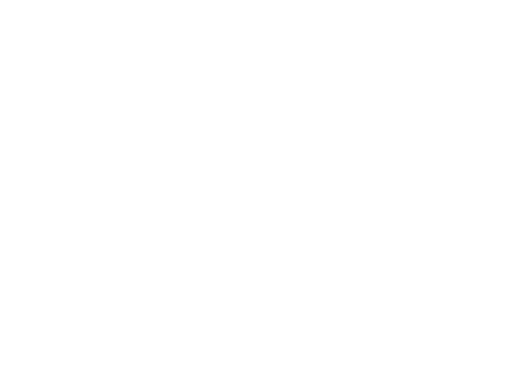

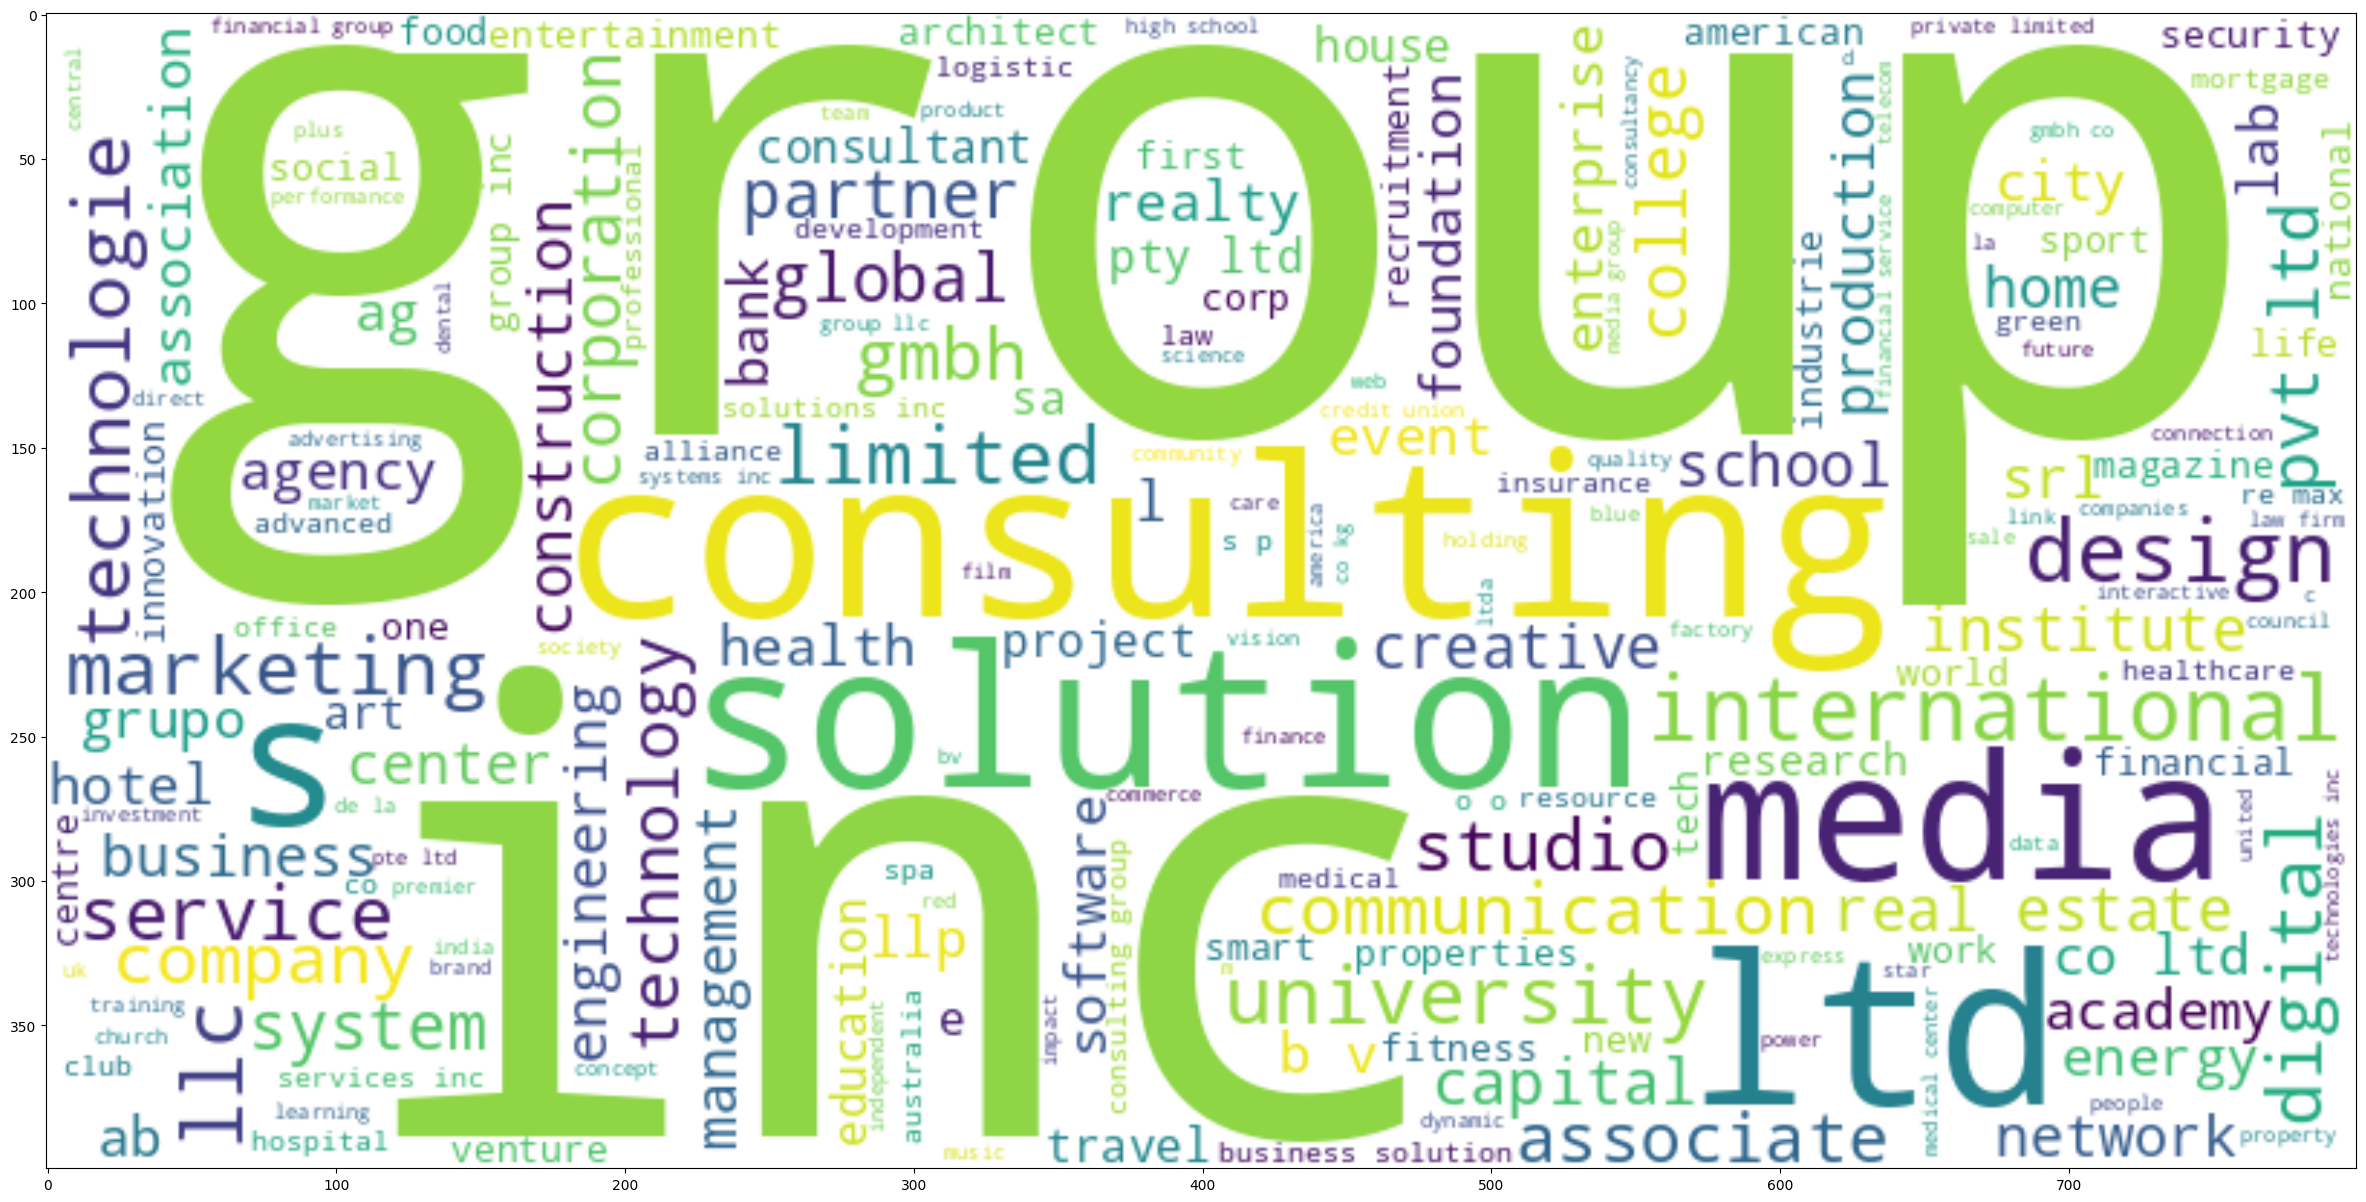

In [34]:
text = " ".join(name for name in df[df.name.isin(repeated_names)].name)

# generate a word cloud image
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

# display the word cloud
plt.axis("off")
plt.figure(figsize=(30,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

The most frequent words in these repeating company names are common words like group, inc, consulting and solution. Having companines with the exact same name in our dataset will conflict with our objective of extracting insights from business names since the values in the other columns differ. So I will remove the companies with their names repeated.

In [35]:
df = df[~df.name.isin(repeated_names)]

Let us examine if there are names containing different kinds of characters other than the english alphabets and space.

In [36]:
# filtering names with a character that is not an english alphabet or space
regexp = re.compile(r'[^a-zA-Z\s]')
df[df.name.apply(lambda x: regexp.search(x)).astype('bool')].name

9                                        at&t
17                       jpmorgan chase & co.
30                     mcdonald's corporation
57           ayatama energi, trisco nusantara
70            secretaría de educación pública
                          ...                
7173397        stone center for yoga & health
7173402                        woonartikel.nl
7173404                     squad sp. z o. o.
7173411    fuller, hadeed, & ros-planas, pllc
7173416                       fit plus s.r.o.
Name: name, Length: 2069320, dtype: string

In [37]:
# filtering names with non-aschii characters, here I considered on the standard aschii characters
regexp = re.compile(r'[^\x00-\x7f]')
df[df.name.apply(lambda x: regexp.search(x)).astype('bool')].name

70                           secretaría de educación pública
81                               verbum traducción y edición
93                                                   l'oréal
168                                   mondelēz international
208                                            itaú unibanco
                                 ...                        
7173288                          uab „plius“ filiāle latvija
7173295           efenex - eficiencia energética extremadura
7173307                                      stora sjöfallet
7173316    versorgungs- und verkehrsgesellschaft saarbrüc...
7173334                iglesia presbiteriana príncipe de paz
Name: name, Length: 286532, dtype: string

In [149]:
# filtering names with digits
regexp = re.compile(r'[0-9]')
df[df.name.apply(lambda x: regexp.search(x)).astype('bool')].name

132                        3m health care
161                                   g4s
456                           century 21®
486                    l-3 communications
535                             ch2m hill
                        ...              
7173166               professionals2match
7173169                    smpn 4 ngaglik
7173364                sia ekspresis 1818
7173378           304000 medienkreationen
7173386    agile4ever consulting services
Name: name, Length: 181870, dtype: object

As shown above there are a lot of names with digits, punctuations and aplhabets from non-english languages. This is understandable as this dataset conatains companies from different countries. Now let us look for the most comon words in company names.

In [ ]:
text = " ".join(name for name in df.name)
print ("There are {} words in the combination of all cells in the column 'name'.".format(len(text)))

# generate a word cloud image
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

# display the word cloud
plt.axis("off")
plt.figure(figsize=(40,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

There are 145466613 words in the combination of all cells in the column 'name'.


###I am not running the code on top as it crasheses the session due to limited RAM runtimes.

We can conclude the following from the word cloud.
* The most common words are related to company structure like pvt, ltd, limited, llc, co, inc, group, and gmbh.
* Country and industry names are also frequent.
* Even though they are not frequent companies use single characters like s, b and v in their names. I assume that these characters are abbreviations and are mmostly followed by a peried(.).

### Domain

In [3]:
# unique value counts
counts_df = df['domain'].value_counts().rename_axis('domain').reset_index(name='count')
counts_df

domain  count
0                        nordalps.com     12
1                          dunked.com      8
2                       virtualcu.net      8
3                    play-cricket.com      8
4                   notjusttravel.com      7
...                               ...    ...
5474759         kishaandtabellion.com      1
5474760                 voice-vpn.com      1
5474761              kern-energie.com      1
5474762                japictures.com      1
5474763  dynamiccontrolssolutions.com      1

[5474764 rows x 2 columns]

In [4]:
df[df['domain'] == 'dunked.com']

Unnamed: 0                        name      domain  year founded  \
3289446     4287707  alex mitchell studios, llc  dunked.com        2003.0   
3467730     6840713     nomad design associates  dunked.com        2017.0   
3748038     6209502    m.cascaes design gráfico  dunked.com        2005.0   
3938133     5110788                 totdetweede  dunked.com        2010.0   
4006830     4731615            creative inkling  dunked.com        2017.0   
4402754     1593044         amber llovet design  dunked.com           NaN   
4496938     1649333                  rjs design  dunked.com           NaN   
5124083      876196                 all rounder  dunked.com        2010.0   

               industry size range                                 locality  \
3289446          design     1 - 10          atlanta, georgia, united states   
3467730          design     1 - 10   london, greater london, united kingdom   
3748038  graphic design     1 - 10                                      NaN   
3938133  graphic design     1 - 10  bergambacht, south holland, netherlands   
4006830          design     1 - 10        godalming, surrey, united kingdom   
4402754          design     1 - 10                                      NaN   
4496938          design     1 - 10    lansdale, pennsylvania, united states   
5124083       animation     1 - 10              barcelona, catalonia, spain   

                country                                    linkedin url  \
3289446   united states  linkedin.com/company/alex-mitchell-studios-llc   
3467730  united kingdom    linkedin.com/company/nomad-design-associates   
3748038          brazil   linkedin.com/company/m.cascaes-design-gr-fico   
3938133     netherlands                linkedin.com/company/totdetweede   
4006830  united kingdom           linkedin.com/company/creative-inkling   
4402754             NaN               linkedin.com/company/amber-llovet   
4496938   united states                  linkedin.com/company/rjsdesign   
5124083           spain                linkedin.com/company/all-rounder   

         current employee estimate  total employee estimate  
3289446                          1                        1  
3467730                          1                        1  
3748038                          1                        1  
3938133                          1                        1  
4006830                          1                        1  
4402754                          1                        1  
4496938                          1                        1  
5124083                          1                        1

We can see that there are companies with the same domain but different name. I assume that there was an error while collecting this data or the data was imputed using some criterea. I am saying this because even sister companies have different domains most of the times. Besides this for example companies with the domain 'dunked.com' are from different countries as shown above. This shows that there is low probability of them being sister companies. But since our objective doesn't focus on the domain, we will not drop them.

### Year founded

In [5]:
# unique value counts
counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='count')
counts_df

year founded   count
0          2015.0  232371
1          2014.0  230781
2          2013.0  221127
3          2012.0  210909
4          2010.0  204021
..            ...     ...
229        2029.0       1
230        1799.0       1
231        1670.0       1
232        1800.0       1
233        1792.0       1

[234 rows x 2 columns]

As shown above there are some historical companies founded before 1900s. Besides this 0 is the most common value because we have repaced null values with it. Let us examine how many companies were founded before the 20th century.

In [6]:
df.query("0 < `year founded` < 1900")['year founded'].value_counts().rename_axis('year founded').reset_index(name='count')

year founded  count
0          1898.0    999
1          1890.0    898
2          1896.0    883
3          1895.0    800
4          1889.0    791
..            ...    ...
101        1799.0      1
102        1800.0      1
103        1670.0      1
104        1451.0      1
105        1792.0      1

[106 rows x 2 columns]

It seems that there are some companies founded in the 19th century. What about before the 19th century?

In [7]:
df.query("0 < `year founded` < 1800")['year founded'].value_counts().rename_axis('year founded').reset_index(name='count')

year founded  count
0        1775.0      3
1        1789.0      2
2        1451.0      1
3        1670.0      1
4        1799.0      1
5        1792.0      1

Earlier we have disovered that the maximum value is 2103. Let us check for vaules bigger than the current year.

In [8]:
df[df['year founded'] > 2021]

Unnamed: 0                                   name  \
478790      5627314    islamabad recruitment company(irco)   
1000988     5403015             st. louis physical therapy   
1685181     2018384                              nativalab   
1911596     2544067                        royal knight ag   
2802880     6660498  b.s.b. international career pvt.  ltd   
2939095     1575236                       creativwire inc.   
3147954     1629514                      stern corporation   
5636056     3036508                  apollo management llc   
6198686     7074029              kass marketing group, llc   
6863658     6229527                             swipes app   
6920143     1102990                              noyfb ltd   

                             domain  year founded  \
478790                  irco.com.pk        2029.0   
1000988                   stlpt.com        2022.0   
1685181               nativalab.com        2023.0   
1911596  royalknightagriculture.com        2027.0   
2802880     bsbinternational.org.uk        2025.0   
2939095             creativwire.com        2103.0   
3147954                sterncorp.jp        2022.0   
5636056         apollomanagement.co        2025.0   
6198686           kassmarketing.com        2022.0   
6863658               getswipes.com        2025.0   
6920143                         NaN        2025.0   

                             industry size range  \
478790   health, wellness and fitness   51 - 200   
1000988  health, wellness and fitness    11 - 50   
1685181                        design    11 - 50   
1911596                       farming     1 - 10   
2802880               human resources     1 - 10   
2939095                      internet     1 - 10   
3147954               mining & metals     1 - 10   
5636056         management consulting     1 - 10   
6198686     marketing and advertising     1 - 10   
6863658                      internet     1 - 10   
6920143               capital markets     1 - 10   

                                      locality        country  \
478790          islamabad, islamabad, pakistan       pakistan   
1000988  chesterfield, missouri, united states  united states   
1685181                milano, lombardy, italy          italy   
1911596  bensalem, pennsylvania, united states  united states   
2802880           calcutta, west bengal, india          india   
2939095      new york, new york, united states  united states   
3147954                    tokyo, tokyo, japan          japan   
5636056                                    NaN            NaN   
6198686       carrollton, texas, united states  united states   
6863658                                    NaN            NaN   
6920143                                    NaN            NaN   

                                              linkedin url  \
478790   linkedin.com/company/islamabad-recruitment-com...   
1000988     linkedin.com/company/st-louis-physical-therapy   
1685181                     linkedin.com/company/nativalab   
1911596               linkedin.com/company/royal-knight-ag   
2802880  linkedin.com/company/b-s-b-international-caree...   
2939095              linkedin.com/company/creativwire-inc-   
3147954             linkedin.com/company/stern-corporation   
5636056         linkedin.com/company/apollo-management-llc   
6198686      linkedin.com/company/kass-marketing-group-llc   
6863658                    linkedin.com/company/swipes-app   
6920143                     linkedin.com/company/noyfb-ltd   

         current employee estimate  total employee estimate  
478790                          19                       34  
1000988                          8                       38  
1685181                          4                        9  
1911596                          3                        4  
2802880                          2                        2  
2939095                          2                        3  
3147954                          2        

Let us remove these records.

In [9]:
df.drop(df.index[df['year founded'] > 2021], inplace=True)

Since most companies in the dataset are founded after 1900, let's see their distribution.

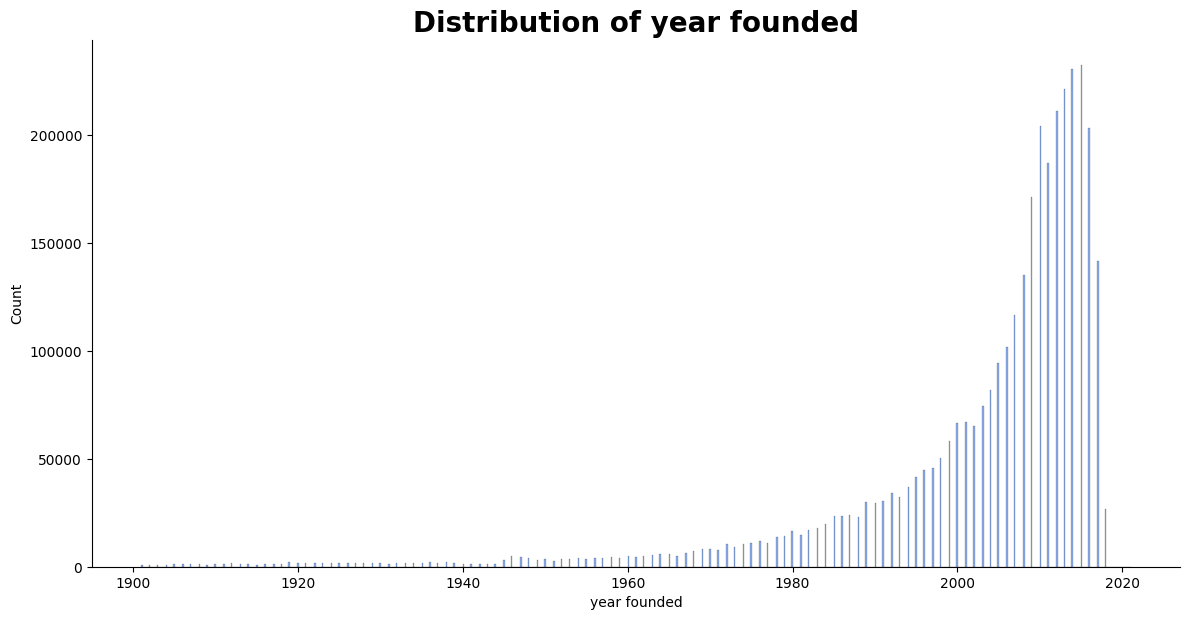

In [16]:
# distribution of companies founded after 1900
plot_dist(df[df['year founded'] > 1900], 'year founded')

### Industry

In [17]:
# unique value counts
counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='count')
counts_df

industry   count
0    information technology and services  453044
1              marketing and advertising  338161
2                           construction  257921
3                  management consulting  194555
4                            real estate  193486
..                                   ...     ...
143                              fishery    2355
144                             ranching    2324
145                 railroad manufacture    1818
146                              tobacco    1354
147                   legislative office     524

[148 rows x 2 columns]

The companies in this dataset work in 148 industries. The most common industry is 'infomation technoogy and services'.

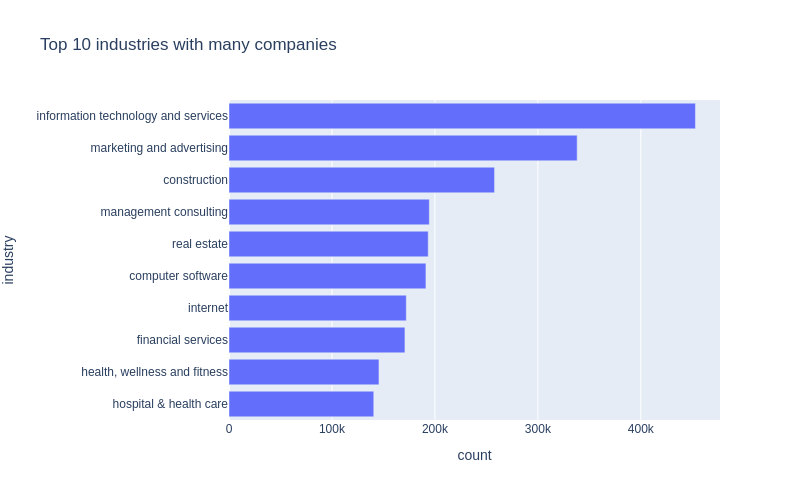

In [18]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with many companies')

### Size range

In [19]:
# unique value counts
counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='count')
counts_df

size range    count
0        1 - 10  5585391
1       11 - 50  1126608
2      51 - 200   324852
3     201 - 500    78494
4    501 - 1000    28394
5   1001 - 5000    24537
6  5001 - 10000     3044
7        10001+     2095

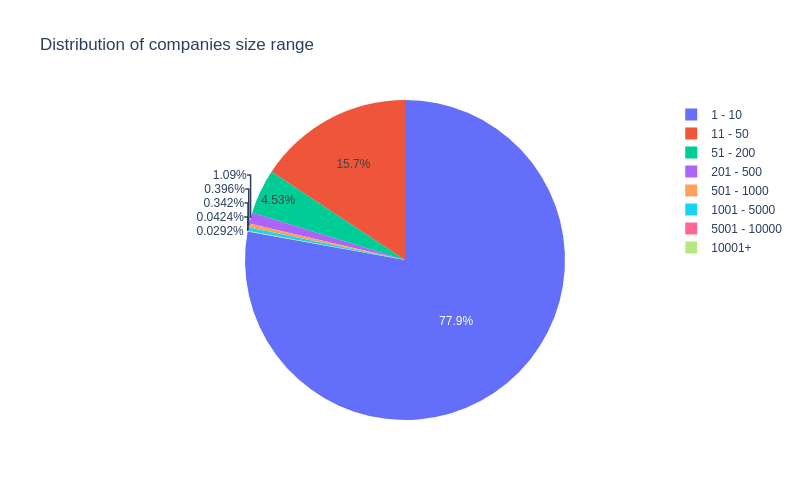

In [20]:
plotly_plot_pie(df, column='size range', title='Distribution of companies size range', width=800)

More than 93% of the companies have employees less than or equal to 50. I think this shows the reaity since the number of big companies that drive economies around the world is small.

### Locality

In [21]:
# unique value counts
counts_df = df['locality'].value_counts().rename_axis('locality').reset_index(name='count')
counts_df

locality  count
0            london, greater london, united kingdom  88225
1                 new york, new york, united states  66466
2                             madrid, madrid, spain  58414
3                      paris, île-de-france, france  34475
4                    london, london, united kingdom  32658
...                                             ...    ...
96239        rittmarshausen, niedersachsen, germany      1
96240  rammingen, baden-württemberg region, germany      1
96241                   cheserex, vaud, switzerland      1
96242               watson, missouri, united states      1
96243  new manchester, west virginia, united states      1

[96244 rows x 2 columns]

Here we can see that most companies are found in the biggest cities of the developed world like london, new york, madrid and paris. Another thing to notice is that london appears both at index 0 and 4 with slight difference. This shows there is an inconsistency. We will extract the cities as a feature later to fix this.

### Country

In [22]:
# unique value counts
counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='count')
counts_df

country    count
0                united states  2278862
1               united kingdom   511969
2                       canada   186621
3                        india   144443
4                        spain   143941
..                         ...      ...
231                       niue        1
232        u.s. virgin islands        1
233             norfolk island        1
234  saint pierre and miquelon        1
235           saint barthélemy        1

[236 rows x 2 columns]

Here also as expected most companies are from the developes countries.The top 10 countries with many companies are plotted below.

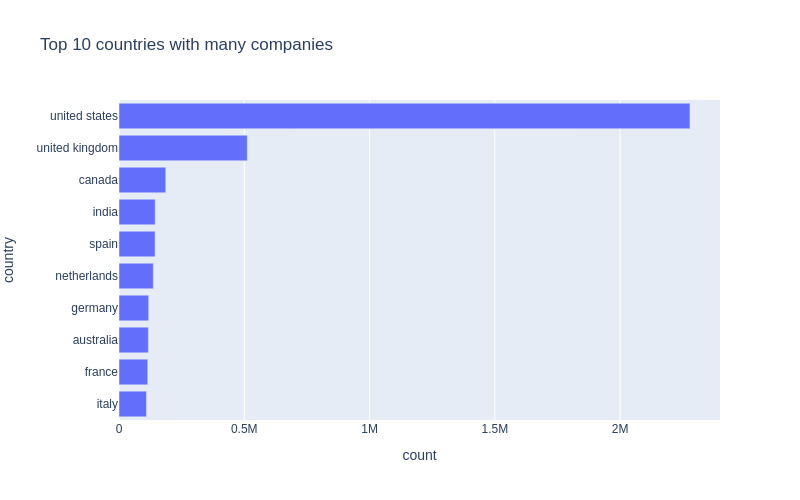

In [23]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='country', title='Top 10 countries with many companies')

 Companies from the united states clearly dominate the dataset.

### Linkedin url

In [24]:

counts_df = df['linkedin url'].value_counts().rename_axis('linkedin url').reset_index(name='count')
counts_df

linkedin url  count
0                                 linkedin.com/company/ibm      1
1        linkedin.com/company/hungarian-table-tennis-as...      1
2                       linkedin.com/company/femme-in-stem      1
3                  linkedin.com/company/pine's-art-gallery      1
4                           linkedin.com/company/tiwiworld      1
...                                                    ...    ...
7173410            linkedin.com/company/anticipationevents      1
7173411  linkedin.com/company/north-rig-catwalk-technol...      1
7173412                 linkedin.com/company/bi-petro-inc-      1
7173413  linkedin.com/company/hämmerling-group-logistic...      1
7173414  linkedin.com/company/dynamic-controls-solution...      1

[7173415 rows x 2 columns]

As shown above each company has its own unique linkedin url. This is because the name of the company, which is unique, is included in each url.

### Current employee estimate

In [25]:
counts_df = df['current employee estimate'].value_counts().rename_axis('current employee estimate').reset_index(name='count')
counts_df

current employee estimate    count
0                             1  2445135
1                             0  1462555
2                             2   963687
3                             3   492590
4                             4   305807
...                         ...      ...
5374                       4566        1
5375                       4570        1
5376                       4574        1
5377                       4575        1
5378                     274047        1

[5379 rows x 2 columns]

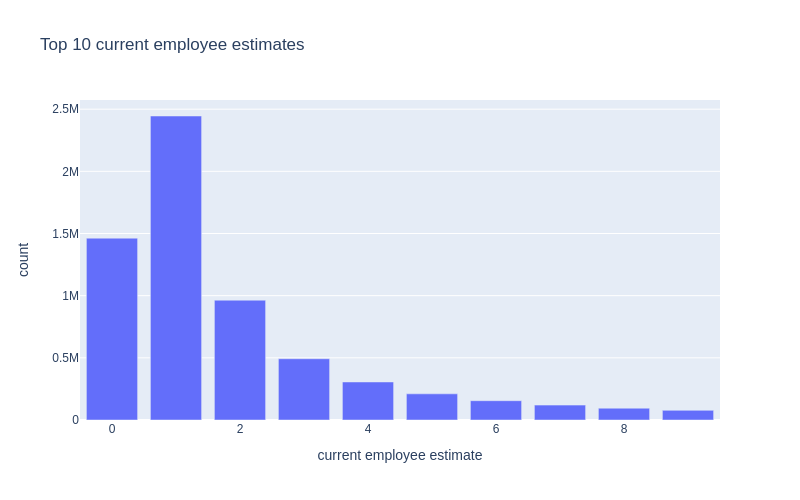

In [26]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='current employee estimate', y='count', title='Top 10 current employee estimates')

Everything seems fine here except for companies with 0 current employee estimate. I assume the data was not available for this companies so 0 was filled as an indication for missing.

### Total employee estimate

In [27]:
counts_df = df['total employee estimate'].value_counts().rename_axis('total employee estimate').reset_index(name='count')
counts_df

total employee estimate    count
0                           1  2588127
1                           2  1122464
2                           3   612085
3                           4   396994
4                           5   282762
...                       ...      ...
8481                    12029        1
8482                     4221        1
8483                     6913        1
8484                    23619        1
8485                     4616        1

[8486 rows x 2 columns]

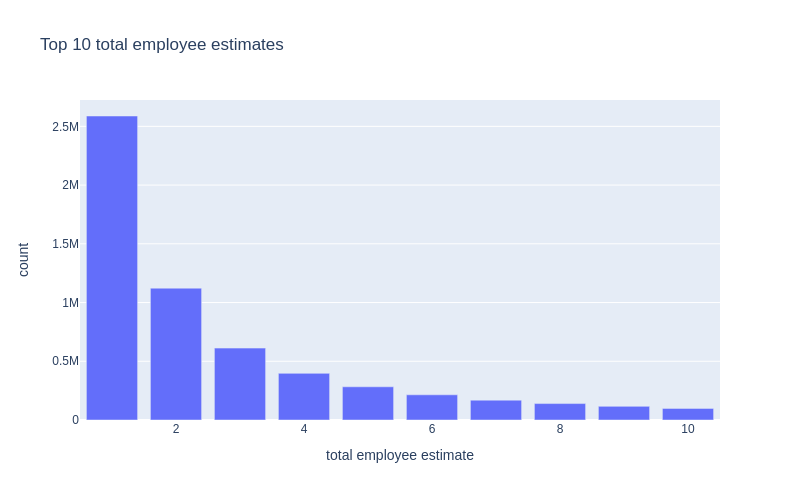

In [28]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='total employee estimate', y='count', title='Top 10 total employee estimates')

Here 0 is the mode value for total employee estimate. I assume this is also due to missing data.

## Feature Engineering

From the locality column we can extract city which is useful to tackle the inconsistency discussed above in the univariate analysis of locality.

In [29]:
def extract_city(locality):
    if pd.isnull(locality):
        return '<NA>'
    # extract cities from locality
    geo = geotext.GeoText(locality).cities
    if len(geo) > 0:
        return geo[0]
    return locality.split(',')[0]

df['city'] = df['locality'].apply(extract_city)

From the name we can extract different features like number of characters, words and punctuations. Another feature to be considered is word density. We can also identify if a name contains digits or non-aschii characters.

In [43]:
df['name_char_count'] = df['name'].apply(lambda name: len(name))

# split name based on comma, space or hyphen
df['name_word_count'] = df['name'].apply(lambda name: len(list(filter(lambda x: x!= '', re.split(r',|\s|-', name)))))

df['name_word_density'] = round(df['name_word_count'] / df['name_char_count'], 2)

punc = string.punctuation
df['name_punc_count'] = df['name'].apply(lambda x : len([a for a in x if a in punc]))

df['name_non_aschii_char_count'] = df['name'].apply(lambda x: len([a for a in x if ord(a) > 127]))

df['name_digit_count'] = df['name'].apply(lambda x: len([a for a in x if a in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']]))

For simplicity and ease of calculating correlation I will categorize the values of 'size range' into number values in an another column.

In [44]:
def categorize(size):
    switcher={
        '1 - 10': 1,
        '11 - 50': 2,
        '51 - 200': 3,
        '201 - 500': 4,
        '501 - 1000': 5,
        '1001 - 5000': 6,
        '5001 - 10000': 7,
        '10001+': 8
    }
    return switcher.get(size, 0)
df['size_category'] = df['size range'].apply(categorize)
df.sample(5)

name                   domain  year founded  \
3863645        kelterei lühn        kelterei-luehn.de           NaN   
374597    mestra informática           megacomusa.com           NaN   
5225010  hr masterpiece, llc        hrmasterpiece.net        2017.0   
2557858    instituto delphis  institutodelphis.com.br        2013.0   
6961781            mio-ecsde            mio-ecsde.org           NaN   

                                   industry size range  \
3863645                    wine and spirits     1 - 10   
374597                  program development   51 - 200   
5225010                     human resources     1 - 10   
2557858                     human resources     1 - 10   
6961781  non-profit organization management     1 - 10   

                                    locality        country  \
3863645                                  NaN            NaN   
374597                                   NaN            NaN   
5225010  norwich, connecticut, united states  united states   
2557858                                  NaN            NaN   
6961781                                  NaN            NaN   

                                    linkedin url  current employee estimate  \
3863645       linkedin.com/company/kelterei-lühn                          1   
374597   linkedin.com/company/mestra-inform-tica                         25   
5225010  linkedin.com/company/hr-masterpiece-llc                          1   
2557858    linkedin.com/company/institutodelphis                          2   
6961781           linkedin.com/company/mio-ecsde                          0   

         total employee estimate     city  name_char_count  name_word_count  \
3863645                        1     <NA>               13                2   
374597                       108     <NA>               18                2   
5225010                        1  norwich               19                3   
2557858                        2     <NA>               17                2   
6961781                        2     <NA>                9                2   

         name_word_density  name_punc_count  name_non_aschii_char_count  \
3863645               0.15                0                           1   
374597                0.11                0                           1   
5225010               0.16                1                           0   
2557858               0.12                0                           0   
6961781               0.22                1                           0   

         name_digit_count  size_category  
3863645                 0              1  
374597                  0              3  
5225010                 0              1  
2557858                 0              1  
6961781                 0              1

## Correlation Analysis

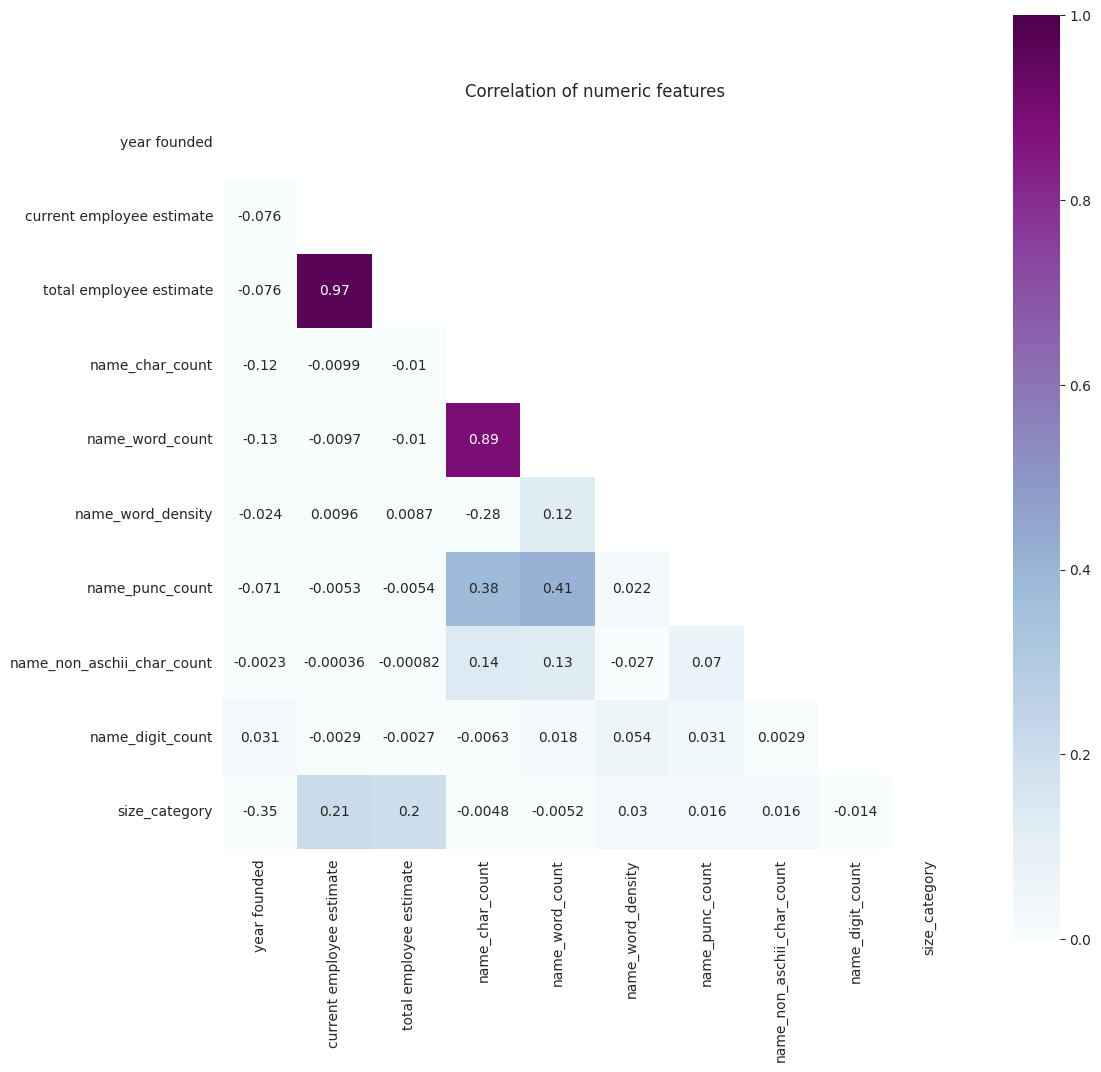

In [45]:
df_corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f_fig, f_ax = plt.subplots(figsize=(12, 12))
    f_ax = sns.heatmap(df_corr, mask=mask, vmin=0, vmax=1, square=True,
                        annot=True, annot_kws={"size": 10}, cmap="BuPu")
plt.title('Correlation of numeric features')
plt.show()

As shown above there is no significant correlation between important numeric features. It is no surprise that 'current employee estimate' and 'total employee estimate' are highly correlated as they both describe the size of employees in companies. The same applies to numeric features engineered from the column name. They have correlation because they are derived from the same place. Due to these facts our bivariate analysis will mostly focus on non-numerical features and their interaction with the numerical features.

## Bivariate Analysis
### country and name_char_count
Here we will examine the averege number of characters in company names per countries.

In [46]:
country_df = df.groupby('country', as_index=False).agg({'name_char_count': 'mean', 'name': 'count'}).rename(columns={'name_char_count': 'mean_name_char', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_char',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_char'] = country_df['mean_name_char'].astype('int16')
country_df

country  mean_name_char   count
0                  China              28   36343
1                  Yemen              27     113
2    Trinidad And Tobago              26     479
3                  Sudan              26     310
4                 Kuwait              26    1735
..                   ...             ...     ...
163               Norway              16   25681
164               France              16  114183
165              Denmark              16   29178
166              Iceland              15    1017
167              Estonia              15    3282

[168 rows x 3 columns]

In [47]:
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))[['name', 'geometry']]
gdf.columns = ['country', 'geometry']
gdf.head()

country                                           geometry
0                      Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...
1                  Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...
2                 W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...
3                    Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...
4  United States of America  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [48]:
# remove antarctica
antarctic_index = int(gdf[gdf['country'] == 'Antarctica'].index.values)
gdf = gdf.drop(gdf.index[antarctic_index])

replace = {
    "United States of America": 'United States',
    "Bosnia and Herz.": 'Bosnia And Herzegovina',
    "Central African Rep.": 'Central African Republic',
    "Côte d'Ivoire": 'Côte D’Ivoire',
    "Dominican Rep.": 'Dominican Republic',
    "Dem. Rep. Congo": 'Democratic Republic Of The Congo',
    "Eq. Guinea": 'Equatorial Guinea',
    "Dominican Rep.": 'Dominican Republic',
    "Solomon Is.": 'Solomon Islands',
    "Trinidad and Tobago": 'Trinidad And Tobago',
    "S. Sudan": 'South Sudan',
}

for (n_old, n_new) in replace.items():
    gdf.country.loc[gdf['country'] == n_old] = n_new

# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_char      count  
0            24.0     1317.0  
1            22.0     1054.0  
2             NaN        NaN  
3            22.0   185327.0  
4            21.0  2234891.0

In [50]:
pip install mapclassify --upgrade


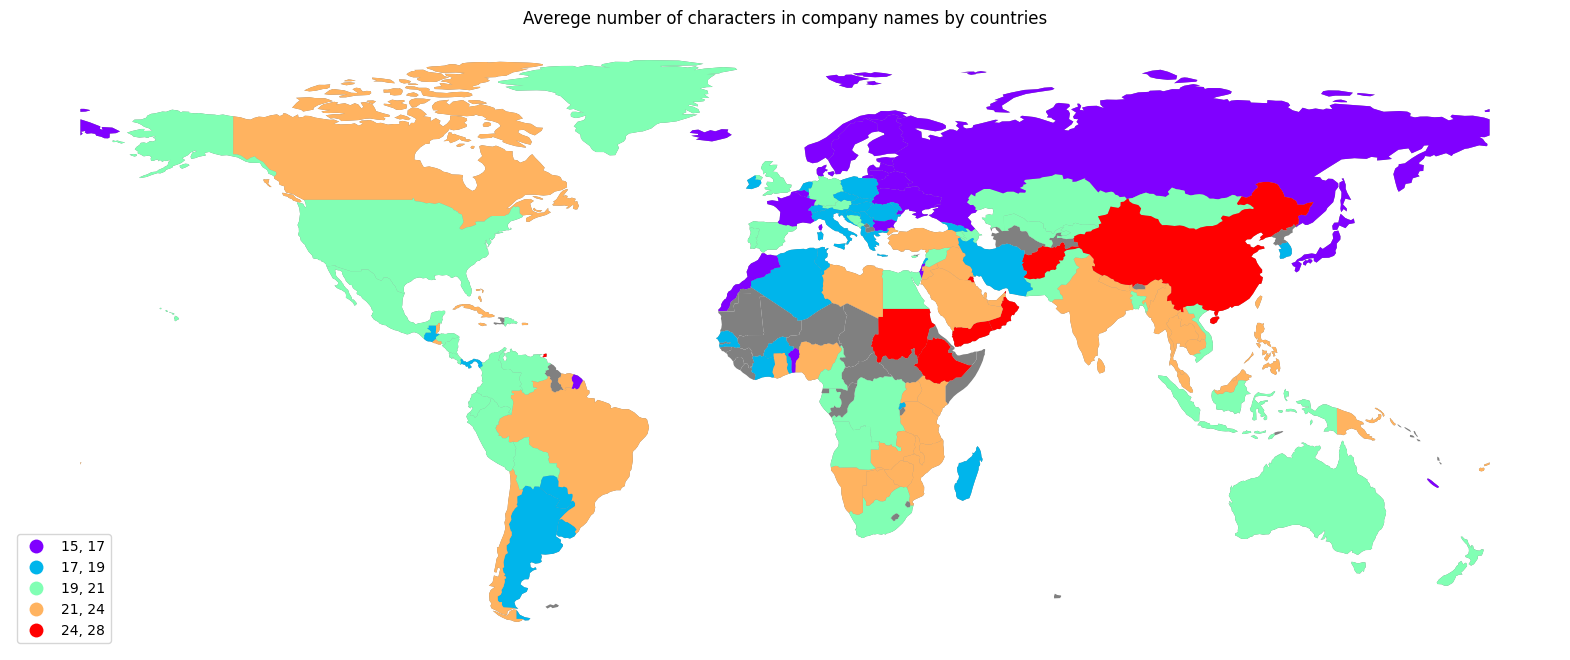

In [51]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_char', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of characters in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

### country and name_word_count

Here we will investigate the averege number of words in company names per countries.

In [52]:
country_df = df.groupby('country', as_index=False).agg({'name_word_count': 'mean', 'name': 'count'}).rename(columns={'name_word_count': 'mean_name_word', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_word',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_word'] = country_df['mean_name_word'].astype('int16')
country_df

country  mean_name_word   count
0      China               4   36343
1      Yemen               3     113
2       Oman               3    1320
3      Sudan               3     310
4     Kuwait               3    1735
..       ...             ...     ...
163   France               2  114183
164  Estonia               2    3282
165  Denmark               2   29178
166  Belarus               2    1043
167  Iceland               2    1017

[168 rows x 3 columns]

In [53]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_word      count  
0             3.0     1317.0  
1             3.0     1054.0  
2             NaN        NaN  
3             3.0   185327.0  
4             3.0  2234891.0

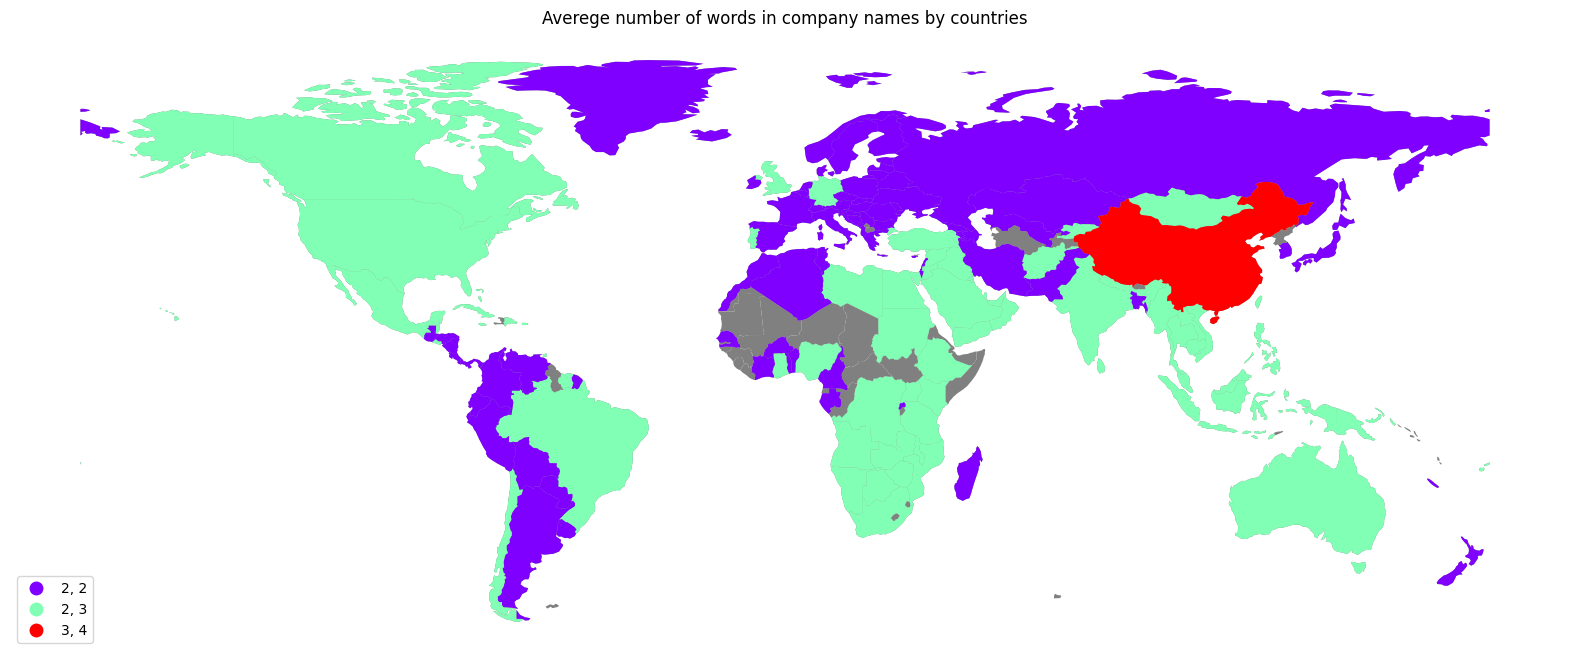

In [54]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_word', cmap='rainbow', ax=ax, scheme='natural_breaks', k=3, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of words in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

There is high similarity with the map showing averege number of characters in company names by countries. It is obvious as there is a correlation between number of characters and words. Some countries with high average number of characters have medium average number of words. I assume the words used by these countries are longer.

### country and name_punc_count

Now it is time for investigating the averege number of punctuations in company names per countries.

In [55]:
country_df = df.groupby('country', as_index=False).agg({'name_punc_count': 'mean', 'name': 'count'}).rename(columns={'name_punc_count': 'mean_name_punct_count', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_punct_count',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_punct_count'] = country_df['mean_name_punct_count'].round(2)
country_df

country  mean_name_punct_count   count
0           Czechia                   1.56   12663
1          Slovenia                   1.46    3282
2          Slovakia                   1.45    4181
3             China                   1.33   36343
4           Croatia                   1.17    4650
..              ...                    ...     ...
163       Australia                   0.20  113248
164         Estonia                   0.20    3282
165  United Kingdom                   0.20  494653
166          Norway                   0.19   25681
167          Sweden                   0.16   34901

[168 rows x 3 columns]

In [56]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_punct_count      count  
0                   0.56     1317.0  
1                   0.36     1054.0  
2                    NaN        NaN  
3                   0.47   185327.0  
4                   0.41  2234891.0

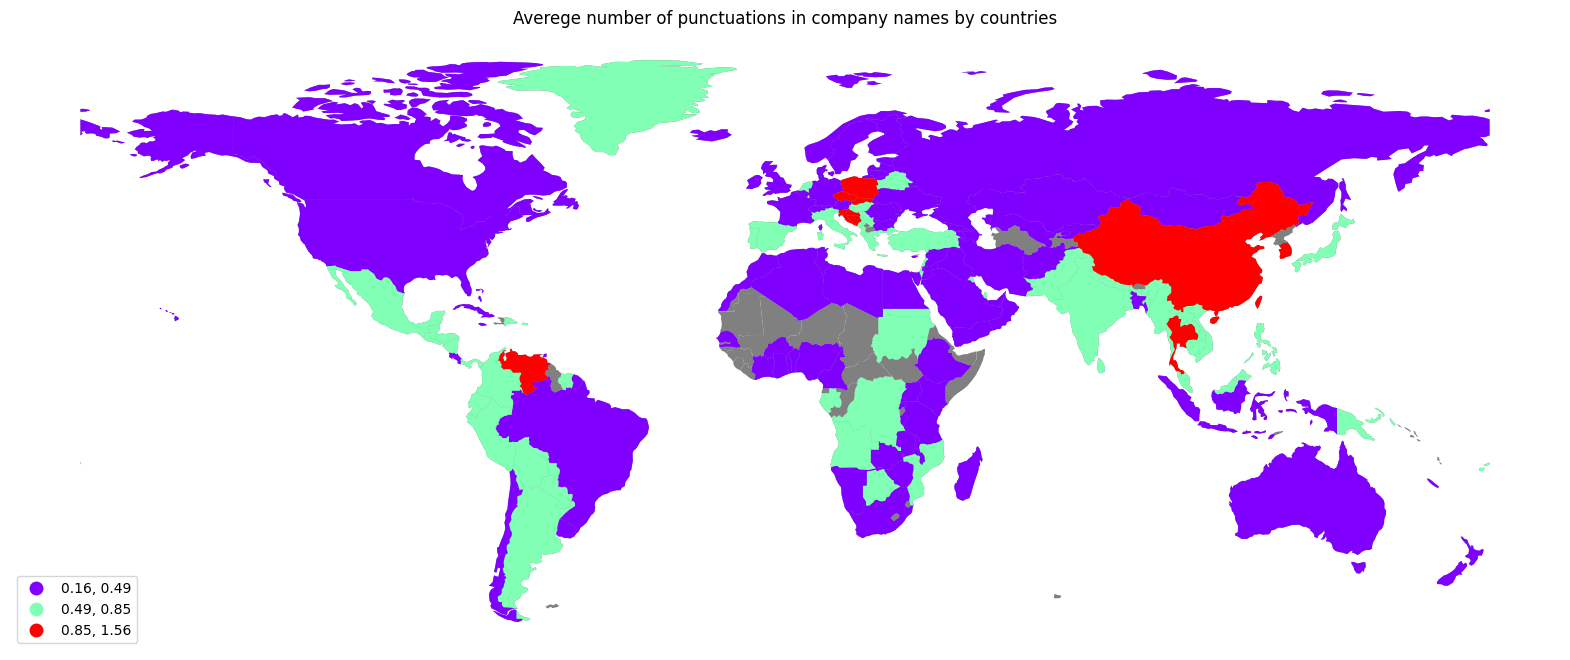

In [57]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_punct_count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=3, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of punctuations in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

Some countries in europe, the south east asia and south america have company names with a high probability of including a punctuation. Let's see who they are.

In [58]:
country_df[country_df['mean_name_punct_count'] >= 1]

country  mean_name_punct_count  count
0    Czechia                   1.56  12663
1   Slovenia                   1.46   3282
2   Slovakia                   1.45   4181
3      China                   1.33  36343
4    Croatia                   1.17   4650
5  Venezuela                   1.04   3859
6     Taiwan                   1.02   3448
7   Thailand                   1.02   5662

### country and name_digit_count
Digits are not that much common in company name. But they appear in some names to represent something, for example, the year they were founded. Let's see if there is a relation between country and average number of digits in company names.

In [59]:
country_df = df.groupby('country', as_index=False).agg({'name_digit_count': 'mean', 'name': 'count'}).rename(columns={'name_digit_count': 'mean_name_digit_count', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_digit_count',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_digit_count'] = country_df['mean_name_digit_count'].round(2)
country_df

country  mean_name_digit_count  count
0          Taiwan                   0.15   3448
1      Guadeloupe                   0.11    175
2     South Korea                   0.11   2135
3    Burkina Faso                   0.11    102
4       Venezuela                   0.10   3859
..            ...                    ...    ...
163          Oman                   0.01   1320
164       Bahamas                   0.00    300
165        Brunei                   0.00    100
166         Yemen                   0.00    113
167    Seychelles                   0.00    132

[168 rows x 3 columns]

The maximum value for average count of digits per country is 0.15 which is very low. This is expected as most company names doesn't include digits.

In [60]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_digit_count      count  
0                   0.02     1317.0  
1                   0.04     1054.0  
2                    NaN        NaN  
3                   0.05   185327.0  
4                   0.04  2234891.0

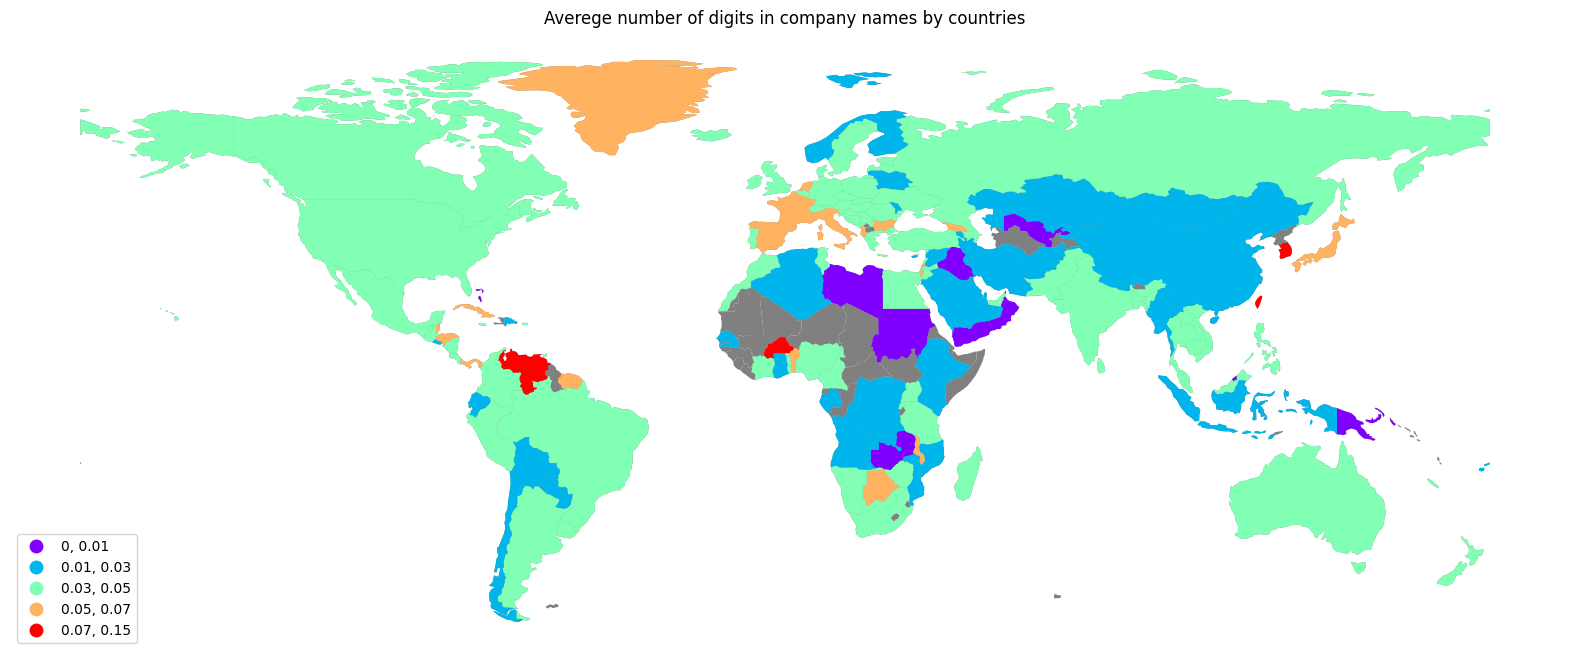

In [61]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_digit_count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of digits in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

In [62]:
country_df[country_df['mean_name_digit_count'] > 0.07]

country  mean_name_digit_count  count
0        Taiwan                   0.15   3448
1    Guadeloupe                   0.11    175
2   South Korea                   0.11   2135
3  Burkina Faso                   0.11    102
4     Venezuela                   0.10   3859

### country and name_non_aschii_char_count

Company names with non-aschii characters are probably going to be from non-english speaking countries. But the question is which countries have the highest number of average non-aschii characters. Let's find out.

In [63]:
country_df = df.groupby('country', as_index=False).agg({'name_non_aschii_char_count': 'mean', 'name': 'count'}).rename(columns={'name_non_aschii_char_count': 'mean_name_non_aschii_char_count', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_non_aschii_char_count',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_non_aschii_char_count'] = country_df['mean_name_non_aschii_char_count'].round(2)
country_df

country  mean_name_non_aschii_char_count  count
0       Belarus                             1.28   1043
1        Turkey                             1.11  35286
2        Russia                             1.07  11816
3    Kazakhstan                             1.02    943
4          Iran                             1.01   7089
..          ...                              ...    ...
163     Bahamas                             0.00    300
164    Tanzania                             0.00   1054
165      Zambia                             0.00    480
166      Belize                             0.00    218
167    Botswana                             0.00    300

[168 rows x 3 columns]

In [64]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_non_aschii_char_count      count  
0                             0.20     1317.0  
1                             0.00     1054.0  
2                              NaN        NaN  
3                             0.07   185327.0  
4                             0.01  2234891.0

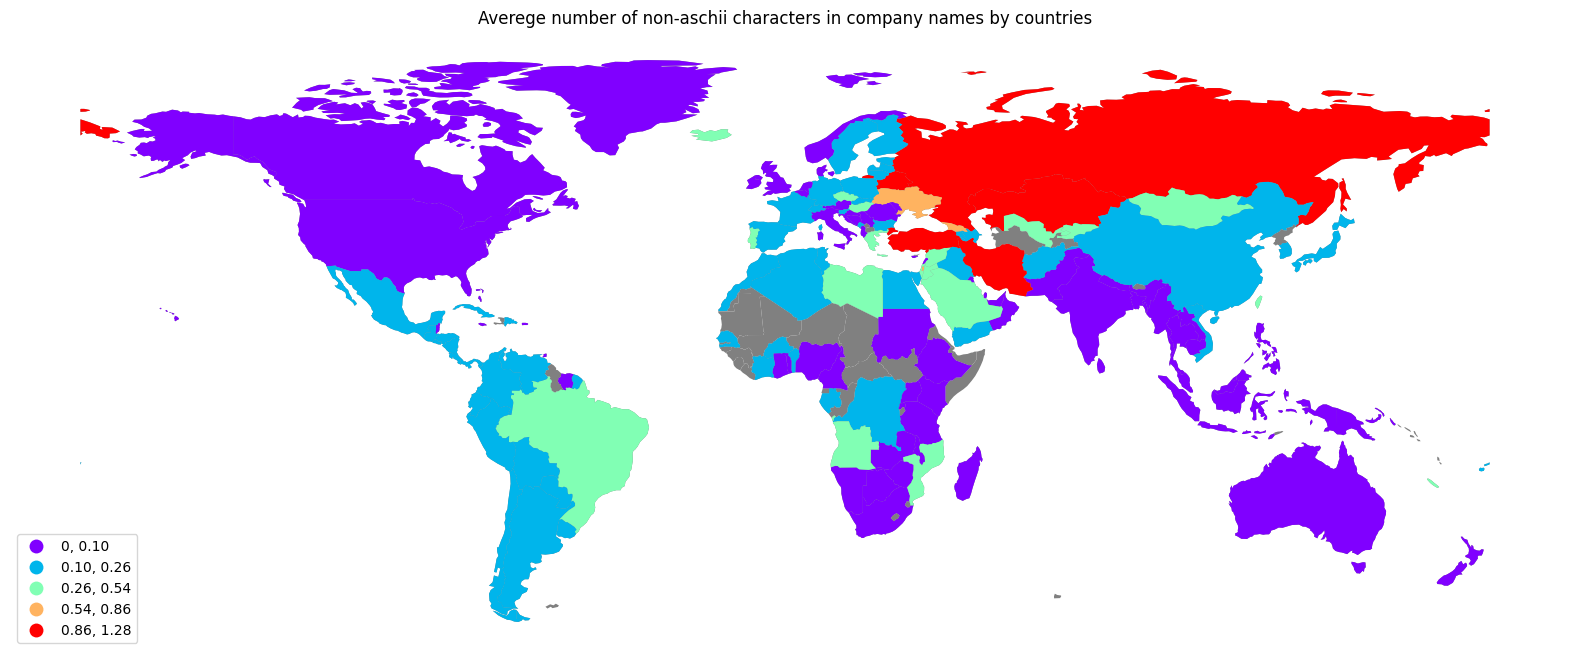

In [65]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_non_aschii_char_count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of non-aschii characters in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

Let's find out which countries are coded by red.

In [66]:
country_df[country_df['mean_name_non_aschii_char_count'] >= 0.97]

country  mean_name_non_aschii_char_count  count
0     Belarus                             1.28   1043
1      Turkey                             1.11  35286
2      Russia                             1.07  11816
3  Kazakhstan                             1.02    943
4        Iran                             1.01   7089

### country and size range

In [67]:
country_df = df.groupby('country', as_index=False).agg({'size_category': 'mean', 'name': 'count'}).rename(columns={'size_category': 'mean_size_category', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_size_category',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_size_category'] = country_df['mean_size_category'].round(2)
country_df

country  mean_size_category    count
0    Papua New Guinea                1.88      242
1               Qatar                1.84     2315
2        Saudi Arabia                1.84     7102
3           Greenland                1.82      100
4              Brunei                1.78      100
..                ...                 ...      ...
163     United States                1.29  2234891
164          Zimbabwe                1.28     2802
165        Guadeloupe                1.26      175
166    United Kingdom                1.23   494653
167       Saint Lucia                1.23      315

[168 rows x 3 columns]

In [68]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_size_category      count  
0                1.70     1317.0  
1                1.52     1054.0  
2                 NaN        NaN  
3                1.34   185327.0  
4                1.29  2234891.0

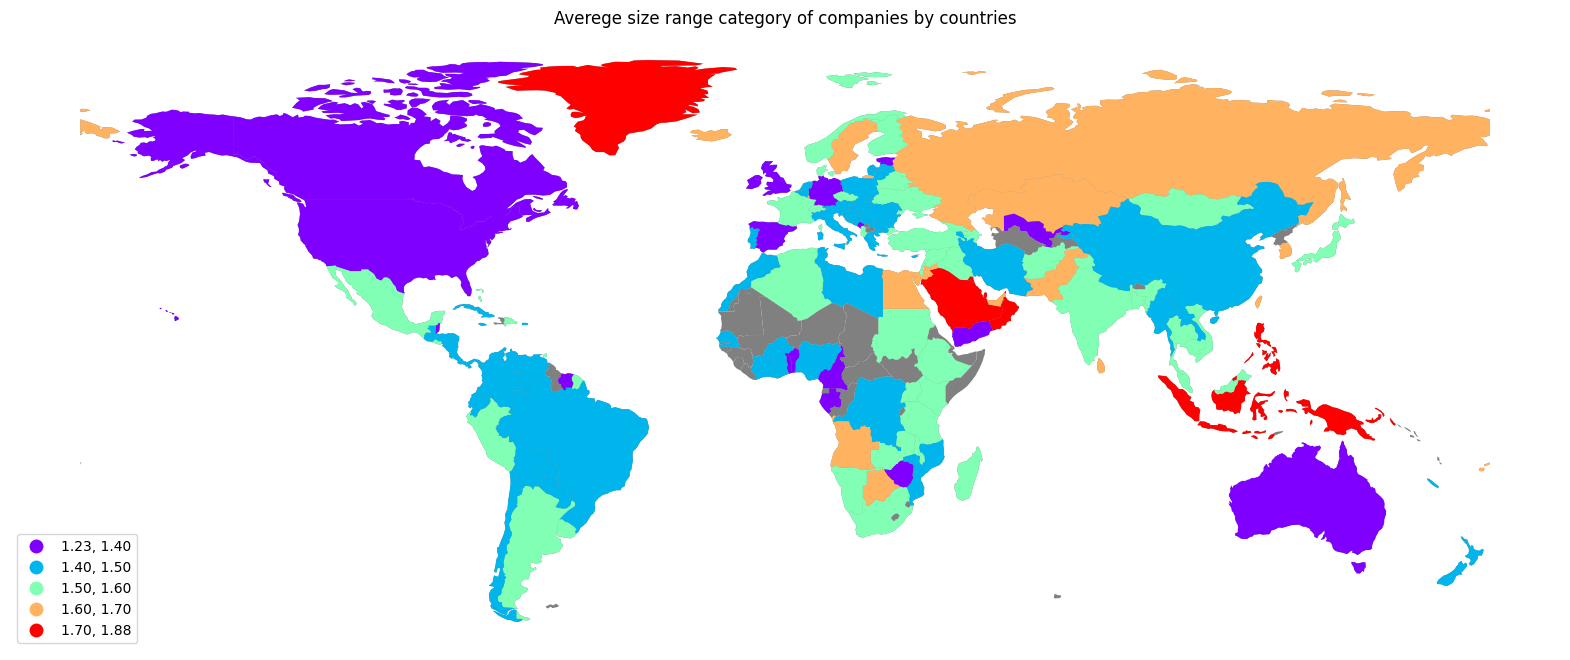

In [69]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_size_category', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege size range category of companies by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

The mean size category ranges from 1.23 to 1.88 in every country with more than or equal to 100 companies in the dataset. This indicates that there are many small companies in these countries which is obvious. That is why the average is lower.

### name and industry
Here we will examine how many and which companies contain words from their respective industries in their names.

In [70]:
def industry_in_name(row):
    puncs = [punc for punc in string.punctuation]
    puncs.append('and')
    industry_words = set(filter(lambda x: x not in puncs, re.split(r'\s|-', row['industry'])))
    name_words = re.split(r'\s|-', row['name'])
    return len([i for i in name_words if i in industry_words])
df['industry_word_in_name_count'] = df.apply(industry_in_name, axis=1)

In [71]:
name_industry_df = df[df['industry_word_in_name_count'] > 0]
name_industry_df

name          domain  year founded  \
1              tata consultancy services         tcs.com        1968.0   
6         cognizant technology solutions   cognizant.com        1994.0   
123                       dxc technology  dxc.technology        2017.0   
136          nyc department of education         nyc.gov           NaN   
172                    farmers insurance     farmers.com        1928.0   
...                                  ...             ...           ...   
7173386   agile4ever consulting services  agile4ever.com        2013.0   
7173398      grund chiropractic wellness             NaN           NaN   
7173405  nextmotion mobility engineering   nextmotion.pt        2012.0   
7173413    a w hargrove insurance agency             NaN           NaN   
7173418            koop media management             NaN           NaN   

                                     industry size range  \
1         information technology and services     10001+   
6         information technology and services     10001+   
123       information technology and services     10001+   
136                      education management     10001+   
172                                 insurance     10001+   
...                                       ...        ...   
7173386                 management consulting     1 - 10   
7173398          health, wellness and fitness     1 - 10   
7173405  mechanical or industrial engineering     1 - 10   
7173413                             insurance     1 - 10   
7173418                       broadcast media     1 - 10   

                                       locality         country  \
1                    bombay, maharashtra, india           india   
6            teaneck, new jersey, united states   united states   
123                                         NaN   united states   
136           new york, new york, united states   united states   
172      los angeles, california, united states   united states   
...                                         ...             ...   
7173386  london, greater london, united kingdom  united kingdom   
7173398   santa rosa, california, united states   united states   
7173405                                     NaN             NaN   
7173413         exmore, virginia, united states   united states   
7173418                                     NaN             NaN   

                                              linkedin url  \
1           linkedin.com/company/tata-consultancy-services   
6                           linkedin.com/company/cognizant   
123                     linkedin.com/company/dxctechnology   
136       linkedin.com/company/nyc-department-of-education   
172                 linkedin.com/company/farmers-insurance   
...                                                    ...   
7173386  linkedin.com/company/agile4ever-consulting-ser...   
7173398   linkedin.com/company/grund-chiropractic-wellness   
7173405                    linkedin.com/company/nextmotion   
7173413  linkedin.com/company/a-w-hargrove-insurance-ag...   
7173418         linkedin.com/company/koop-media-management   

         current employee estimate  total employee estimate         city  \
1                           190771                   341369       bombay   
6                           122031                   210020      teaneck   
123                          31671                    39585         <NA>   
136                          30526                    45049     new york   
172                          26029                    50471  los angeles   
...                            ...                      ...          ...   
7173386                          0                        2       london   
7173398                          0                        1   santa rosa   
7173405                          0                        1         <NA>   
7173413                          0                        1       exmore   
7173418                          0      

Let's explore these companies with respect to their country, size range, industry and year founded.

#### industry_word_in_name_count and country

In [72]:
country_df = name_industry_df.groupby('country', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
country_df =  country_df.sort_values(by='count',ascending=False).reset_index(drop=True)
country_counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='total_count')
country_df = country_df.merge(country_counts_df, left_on='country', right_on='country', how = 'left')
country_df['country'] = country_df['country'].astype('string').str.title()
country_df

country   count  total_count
0          United States  250863      2234891
1         United Kingdom   51268       494653
2                 Canada   23201       185327
3                  India   14302       140800
4              Australia   13446       113248
..                   ...     ...          ...
213           Micronesia       1            5
214  U.S. Virgin Islands       1            1
215               Tuvalu       1           25
216               Guyana       1           49
217                Samoa       1           24

[218 rows x 3 columns]

In [73]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry     count  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...     164.0   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...     111.0   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...       NaN   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   23201.0   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  250863.0   

   total_count  
0       1317.0  
1       1054.0  
2          NaN  
3     185327.0  
4    2234891.0

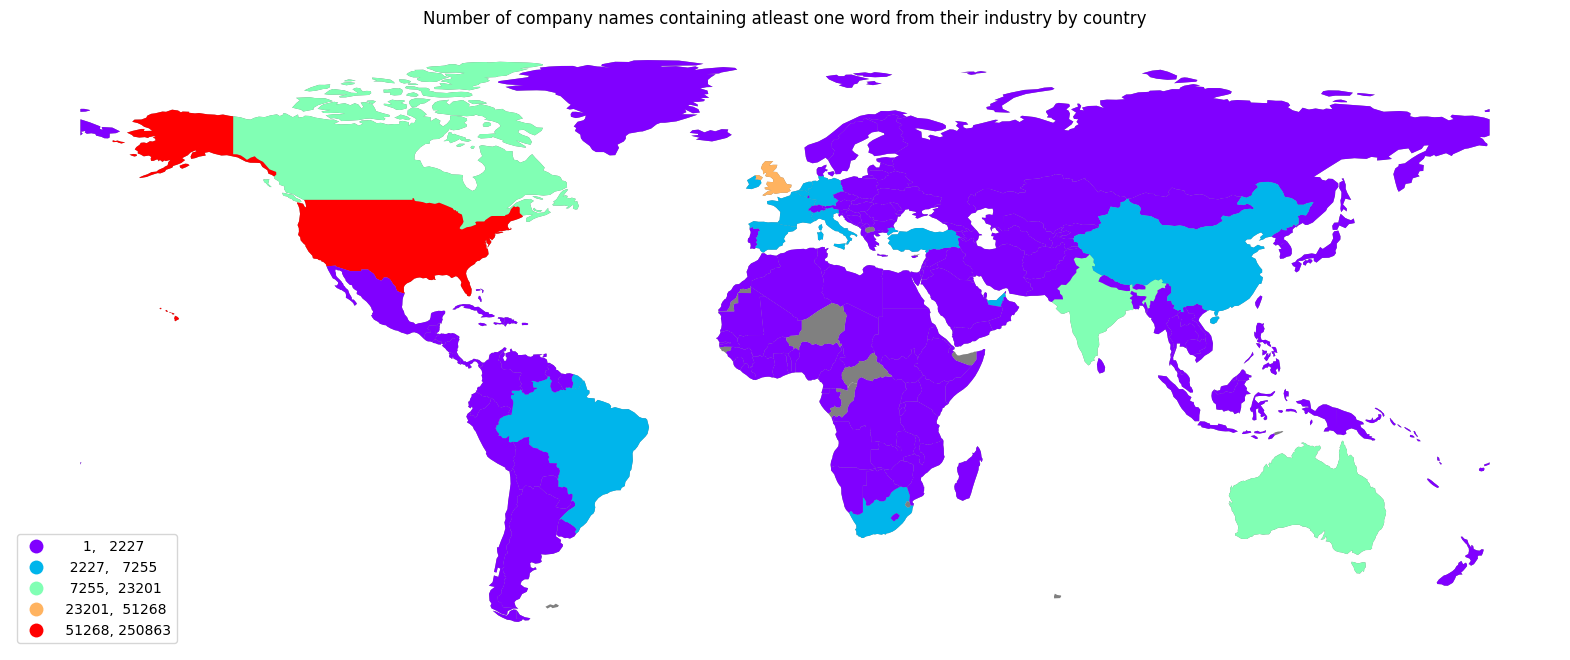

In [74]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Number of company names containing atleast one word from their industry by country')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

The united states dominates here. But this maybe due to its high number of companies in the dataset as compared to other companies.

#### industry_word_in_name_count and size range

Let us check if these names are related to size range.

In [75]:
size_df = name_industry_df.groupby('size range', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
size_counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='total_count')
size_df = size_df.merge(size_counts_df, left_on='size range', right_on='size range', how = 'left')
size_df =  size_df.sort_values(by='count',ascending=False).reset_index(drop=True)
size_df

size range   count  total_count
0        1 - 10  487273      5295776
1       11 - 50  100775      1126224
2      51 - 200   27521       324845
3     201 - 500    6534        78494
4    501 - 1000    2395        28394
5   1001 - 5000    2120        24537
6  5001 - 10000     272         3044
7        10001+     142         2095

As we can see from the result above, small sized companies tend to have more companies with names conataining atleast a word from their respective industries. This aligns with the general distibution of size range. So I don't think there is a special connection here.

#### industry_word_in_name_count and industry

Let us check if these names are related to which industry.

In [76]:
industry_df = name_industry_df.groupby('industry', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
industry_counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='total_count')
industry_df = industry_df.merge(industry_counts_df, left_on='industry', right_on='industry', how = 'left')
industry_df =  industry_df.sort_values(by='count',ascending=False).reset_index(drop=True)
industry_df

industry  count  total_count
0              marketing and advertising  43181       338161
1                  management consulting  33470       194555
2                           construction  28718       257921
3                 hospital & health care  26803       140594
4    information technology and services  26530       453043
..                                   ...    ...          ...
141               religious institutions     28        29537
142                              fishery     21         2355
143                            judiciary     15         3926
144                             ranching      3         2324
145               outsourcing/offshoring      1        13925

[146 rows x 3 columns]

In [77]:
industry_df.head(10)

industry  count  total_count
0            marketing and advertising  43181       338161
1                management consulting  33470       194555
2                         construction  28718       257921
3               hospital & health care  26803       140594
4  information technology and services  26530       453043
5                            insurance  23832        70771
6                               design  22518       120152
7                   financial services  22478       170880
8                          real estate  21396       193486
9                         law practice  20926        81632

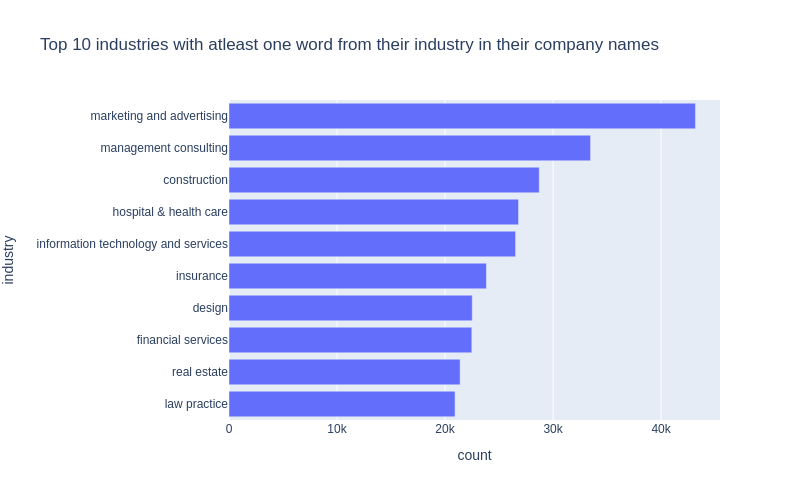

In [78]:
plotly_plot_bar(industry_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with atleast one word from their industry in their company names')

The bar chart plotted above shows top 10 industries with words from their respective industry in their company names.

#### industry_word_in_name_count and year founded

In [79]:
year_df = name_industry_df.groupby('year founded', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
year_df = year_df[year_df['year founded'] != 0]
year_counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='total_count')
year_df = year_df.merge(year_counts_df, left_on='year founded', right_on='year founded', how = 'left')
year_df =  year_df.sort_values(by='count',ascending=False).reset_index(drop=True)
year_df['year founded'] = year_df['year founded'].astype('string')
year_df

year founded  count  total_count
0         2010.0  21002       203998
1         2014.0  20305       230739
2         2013.0  19953       221088
3         2015.0  19908       232311
4         2012.0  19414       210867
..           ...    ...          ...
213       1823.0      2           66
214       1825.0      2           84
215       1815.0      2           63
216       1827.0      1           62
217       1829.0      1           91

[218 rows x 3 columns]

In [80]:
year_df.head(10)

year founded  count  total_count
0       2010.0  21002       203998
1       2014.0  20305       230739
2       2013.0  19953       221088
3       2015.0  19908       232311
4       2012.0  19414       210867
5       2011.0  18176       187175
6       2009.0  18164       171196
7       2016.0  17625       203133
8       2008.0  14049       135230
9       2017.0  13001       141693

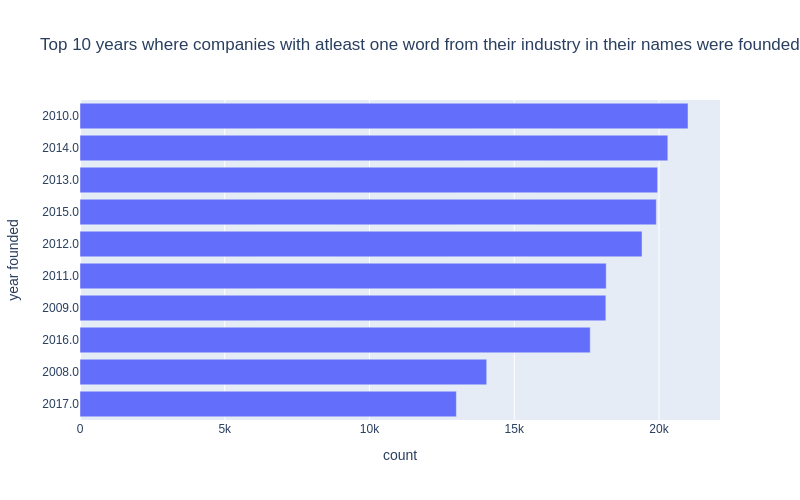

In [81]:
plotly_plot_bar(year_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='year founded', title='Top 10 years where companies with atleast one word from their industry in their names were founded')

### name and locality

Here we will examine how many and which companies contain words from their respective localities in their names.

In [82]:
def locality_in_name(row):
    if pd.isnull(row['locality']):
        return np.nan
    puncs = [punc for punc in string.punctuation]
    puncs.append('and')
    locality_words = set(filter(lambda x: x not in puncs, re.split(r'\s|-', row['locality'])))
    name_words = re.split(r'\s|-', row['name'])
    return len([i for i in name_words if i in locality_words])
df['locality_word_in_name_count'] = df.apply(locality_in_name, axis=1)

In [83]:
name_locality_df = df[df['locality_word_in_name_count'] > 0]
name_locality_df

name                    domain  \
10                  united states air force              airforce.com   
29             united states postal service                  usps.com   
38           department of veterans affairs                    va.gov   
82               united states marine corps               marines.com   
160                            saudi aramco           saudiaramco.com   
...                                     ...                       ...   
7173163                    new york telecom                       NaN   
7173176   ladies & gentlemen - south africa  ladiesandgentlemen.co.za   
7173189  saudi speciality chemicals company                       NaN   
7173208                  iran model company             iranmodel.com   
7173370                        cia do movel     emporiodomovel.com.br   

         year founded                              industry size range  \
10             1947.0                       defense & space     10001+   
29                NaN             government administration     10001+   
38             1930.0             government administration     10001+   
82                NaN                              military     10001+   
160            1933.0                          oil & energy     10001+   
...               ...                                   ...        ...   
7173163           NaN                    telecommunications     1 - 10   
7173176        2011.0                      media production     1 - 10   
7173189           NaN                             chemicals     1 - 10   
7173208        1984.0  mechanical or industrial engineering     1 - 10   
7173370        2002.0                             furniture     1 - 10   

                                                locality        country  \
10                        randolph, texas, united states  united states   
29       washington, district of columbia, united states  united states   
38       washington, district of columbia, united states  united states   
82       washington, district of columbia, united states  united states   
160              dhahran, eastern province, saudi arabia   saudi arabia   
...                                                  ...            ...   
7173163               hoboken, new jersey, united states  united states   
7173176              johannesburg, gauteng, south africa   south africa   
7173189           jubail, eastern province, saudi arabia   saudi arabia   
7173208                             tehran, tehrān, iran           iran   
7173370             igrejinha, rio grande do sul, brazil         brazil   

                                              linkedin url  \
10            linkedin.com/company/united-states-air-force   
29                               linkedin.com/company/usps   
38       linkedin.com/company/department-of-veterans-af...   
82         linkedin.com/company/united-states-marine-corps   
160                      linkedin.com/company/saudi-aramco   
...                                                    ...   
7173163              linkedin.com/company/new-york-telecom   
7173176  linkedin.com/company/ladies-&-gentlemen---sout...   
7173189  linkedin.com/company/saudi-speciality-chemical...   
7173208            linkedin.com/company/iran-model-company   
7173370              linkedin.com/company/empório-do-móvel   

         current employee estimate  total employee estimate          city  \
10                          113997                   316549      randolph   
29                           74357                   104159    washington   
38                           62685                    86489    washington   
82                           38917                   165778    washington   
160                          27631                    40870       dhahran   
...                            ...                      ...           ...   
7173163                          0                       12       hoboken   
7173176    

Let's explore these companies with respect to their country, size range, industry and year founded.

#### locality_word_in_name_count and country

In [84]:
country_df = name_locality_df.groupby('country', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
country_df =  country_df.sort_values(by='count',ascending=False).reset_index(drop=True)
country_counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='total_count')
country_df = country_df.merge(country_counts_df, left_on='country', right_on='country', how = 'left')
country_df['country'] = country_df['country'].astype('string').str.title()
country_df

country  count  total_count
0       United States  45381      2234891
1               India  19598       140800
2           Australia   6757       113248
3              Canada   6303       185327
4              France   6297       114183
..                ...    ...          ...
201          Kiribati      1           62
202        Kyrgyzstan      1          109
203  Marshall Islands      1           18
204        Micronesia      1            5
205     Åland Islands      1           48

[206 rows x 3 columns]

In [85]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry    count  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...    172.0   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...    212.0   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...      NaN   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   6303.0   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  45381.0   

   total_count  
0       1317.0  
1       1054.0  
2          NaN  
3     185327.0  
4    2234891.0

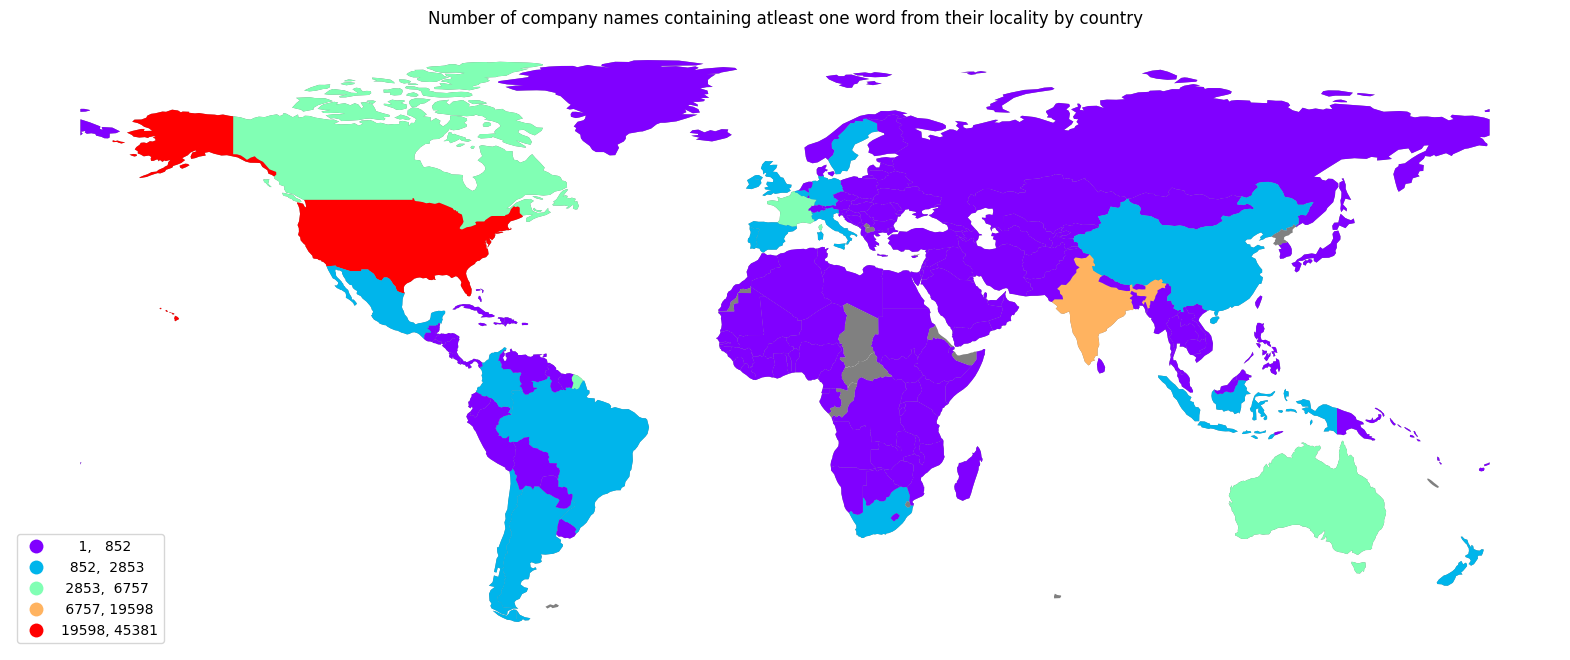

In [86]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Number of company names containing atleast one word from their locality by country')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

#### locality_word_in_name_count and size range

In [87]:
size_df = name_locality_df.groupby('size range', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
size_counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='total_count')
size_df = size_df.merge(size_counts_df, left_on='size range', right_on='size range', how = 'left')
size_df =  size_df.sort_values(by='count',ascending=False).reset_index(drop=True)
size_df

size range  count  total_count
0        1 - 10  92681      5295776
1       11 - 50  29195      1126224
2      51 - 200  11201       324845
3     201 - 500   3227        78494
4    501 - 1000   1349        28394
5   1001 - 5000   1247        24537
6  5001 - 10000    156         3044
7        10001+     98         2095

As we can see from the result above, small sized companies tend to have more companies with names conataining atleast a word from their respective localities. This aligns with the general distibution of size range. So I don't think there is a special connection here.

#### locality_word_in_name_count and industry

In [88]:
industry_df = name_locality_df.groupby('industry', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
industry_counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='total_count')
industry_df = industry_df.merge(industry_counts_df, left_on='industry', right_on='industry', how = 'left')
industry_df =  industry_df.sort_values(by='count',ascending=False).reset_index(drop=True)
industry_df

industry  count  total_count
0    information technology and services   6836       453043
1     non-profit organization management   6160        99075
2                   education management   5547       136745
3                 hospital & health care   4367       140594
4              marketing and advertising   4177       338161
..                                   ...    ...          ...
143                             ranching     40         2324
144                         supermarkets     39         2859
145                              tobacco     38         1354
146                       nanotechnology     34         2536
147                   legislative office     25          524

[148 rows x 3 columns]

In [89]:
industry_df.head(10)

industry  count  total_count
0  information technology and services   6836       453043
1   non-profit organization management   6160        99075
2                 education management   5547       136745
3               hospital & health care   4367       140594
4            marketing and advertising   4177       338161
5                          hospitality   3783        98040
6                          real estate   3771       193486
7                         construction   3227       257921
8         health, wellness and fitness   2955       145669
9                           automotive   2918       104143

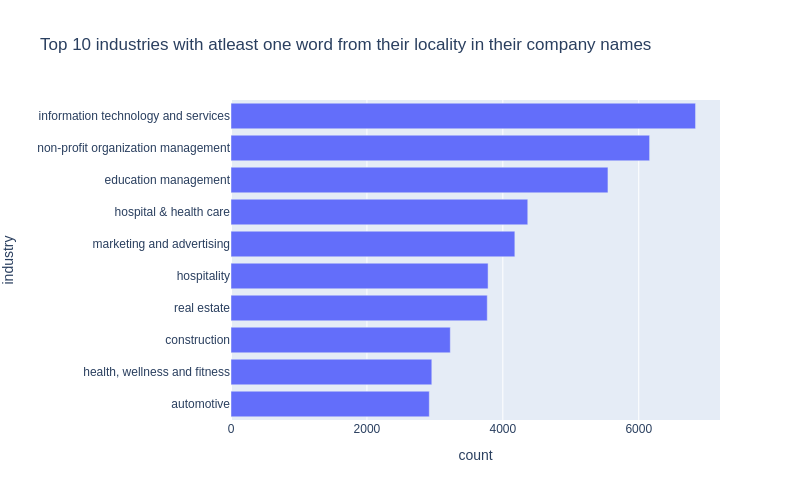

In [90]:
plotly_plot_bar(industry_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with atleast one word from their locality in their company names')

The bar chart plotted above shows top 10 industries with words from their respective locality in their company names.

#### locality_word_in_name_count and year founded

In [91]:
year_df = name_locality_df.groupby('year founded', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
year_df = year_df[year_df['year founded'] != 0]
year_counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='total_count')
year_df = year_df.merge(year_counts_df, left_on='year founded', right_on='year founded', how = 'left')
year_df =  year_df.sort_values(by='count',ascending=False).reset_index(drop=True)
year_df['year founded'] = year_df['year founded'].astype('string')
year_df

year founded  count  total_count
0         2012.0   3597       210867
1         2013.0   3551       221088
2         2014.0   3544       230739
3         2015.0   3472       232311
4         2010.0   3326       203998
..           ...    ...          ...
216       1802.0      2           45
217       1451.0      1            1
218       1789.0      1            2
219       1815.0      1           63
220       2019.0      1           17

[221 rows x 3 columns]

In [92]:
year_df.head(10)

year founded  count  total_count
0       2012.0   3597       210867
1       2013.0   3551       221088
2       2014.0   3544       230739
3       2015.0   3472       232311
4       2010.0   3326       203998
5       2011.0   3142       187175
6       2009.0   2852       171196
7       2016.0   2773       203133
8       2008.0   2636       135230
9       2007.0   2268       116720

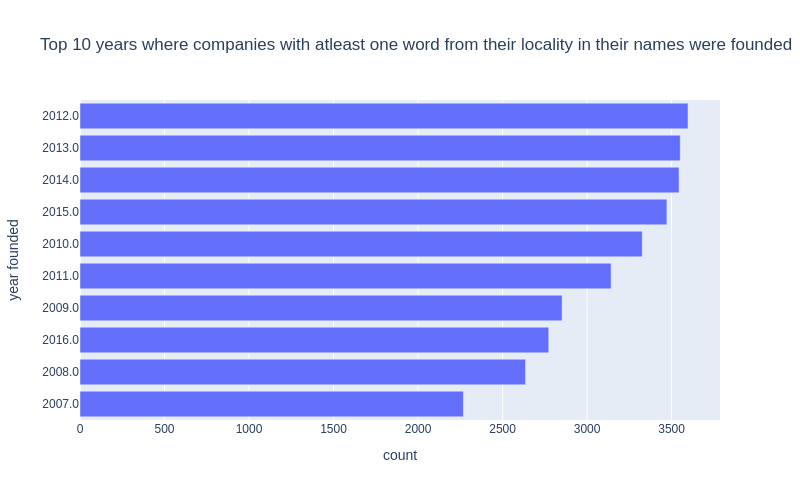

In [93]:
plotly_plot_bar(year_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='year founded', title='Top 10 years where companies with atleast one word from their locality in their names were founded')

### name and year founded

Here we will examine how many and which companies contain words from their respective years they were founded in their names.

In [94]:
def year_in_name(row):
    if (row['year founded'] == 0):
        return None
    year = row['year founded']
    regexp = re.compile(f'{year}')
    return regexp.search(row['name'])

df['year_in_name'] = df.apply(year_in_name, axis=1).astype('bool').astype('int16')

In [95]:
name_year_df = df[df['year_in_name'] > 0]
name_year_df

name                  domain  \
1322                   allstate financial                     NaN   
1389           marsh & mclennan companies                 mmc.com   
1655                  ministry of finance                  nrw.de   
1677     nanyang technological university              ntu.edu.sg   
2106                  synchrony financial  synchronyfinancial.com   
...                                   ...                     ...   
7171929      nanakusa japanese restaurant        dinenanakusa.com   
7172310        pride financial group ltd.    myfinancialpride.com   
7172325             pregnancy test center       ptcbirmingham.com   
7173120                johnston financial                     NaN   
7173339                          buynance             uccfeed.com   

         year founded                      industry    size range  \
1322              NaN            financial services        10001+   
1389              NaN            financial services        10001+   
1655              NaN     government administration        10001+   
1677              NaN              higher education        10001+   
2106              NaN            financial services  5001 - 10000   
...               ...                           ...           ...   
7171929           NaN       architecture & planning        1 - 10   
7172310           NaN            financial services        1 - 10   
7172325           NaN  health, wellness and fitness        1 - 10   
7173120           NaN            financial services        1 - 10   
7173339           NaN            financial services        1 - 10   

                                     locality        country  \
1322         lincoln, nebraska, united states  united states   
1389        new york, new york, united states  united states   
1655                                      NaN            NaN   
1677                                      NaN      singapore   
2106     stamford, connecticut, united states  united states   
...                                       ...            ...   
7171929   milwaukee, wisconsin, united states  united states   
7172310                                   NaN            NaN   
7172325      bessemer, alabama, united states  united states   
7173120  tamworth, new south wales, australia      australia   
7173339                                   NaN            NaN   

                                              linkedin url  \
1322               linkedin.com/company/allstate-financial   
1389     linkedin.com/company/marsh-&-mclennan-companie...   
1655              linkedin.com/company/ministry-of-finance   
1677                            linkedin.com/company/ntusg   
2106              linkedin.com/company/synchrony-financial   
...                                                    ...   
7171929  linkedin.com/company/nanakusa-japanese-restaurant   
7172310            linkedin.com/company/my-financial-pride   
7172325         linkedin.com/company/pregnancy-test-center   
7173120            linkedin.com/company/johnston-financial   
7173339                      linkedin.com/company/buynance   

         current employee estimate  total employee estimate  ...  \
1322                          5880                     8360  ...   
1389                          5596                    14525  ...   
1655                          4942                     8251  ...   
1677                          4886                    12218  ...   
2106                          4117                     5237  ...   
...                            ...                      ...  ...   
7171929                          0                        1  ...   
7172310                          0                        1  ...   
7172325                          0                        1  ...   
7173120                          0                        1  ...   
7173339                          0                        1  ...   

        name_char_count  name_word_count  name_w

Let's explore these companies with respect to their country, size range, industry and year founded.

#### year_in_name and country

In [96]:
country_df = name_year_df.groupby('country', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
country_df =  country_df.sort_values(by='count',ascending=False).reset_index(drop=True)
country_counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='total_count')
country_df = country_df.merge(country_counts_df, left_on='country', right_on='country', how = 'left')
country_df['country'] = country_df['country'].astype('string').str.title()
country_df

country  count  total_count
0     United States  11457      2234891
1    United Kingdom   3241       494653
2            Canada    645       185327
3         Australia    580       113248
4             India    556       140800
..              ...    ...          ...
139         Georgia      1         1287
140           Sudan      1          310
141          Gambia      1           40
142         Namibia      1          384
143      Kazakhstan      1          943

[144 rows x 3 columns]

In [97]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry    count  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...      5.0   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...      2.0   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...      NaN   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...    645.0   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  11457.0   

   total_count  
0       1317.0  
1       1054.0  
2          NaN  
3     185327.0  
4    2234891.0

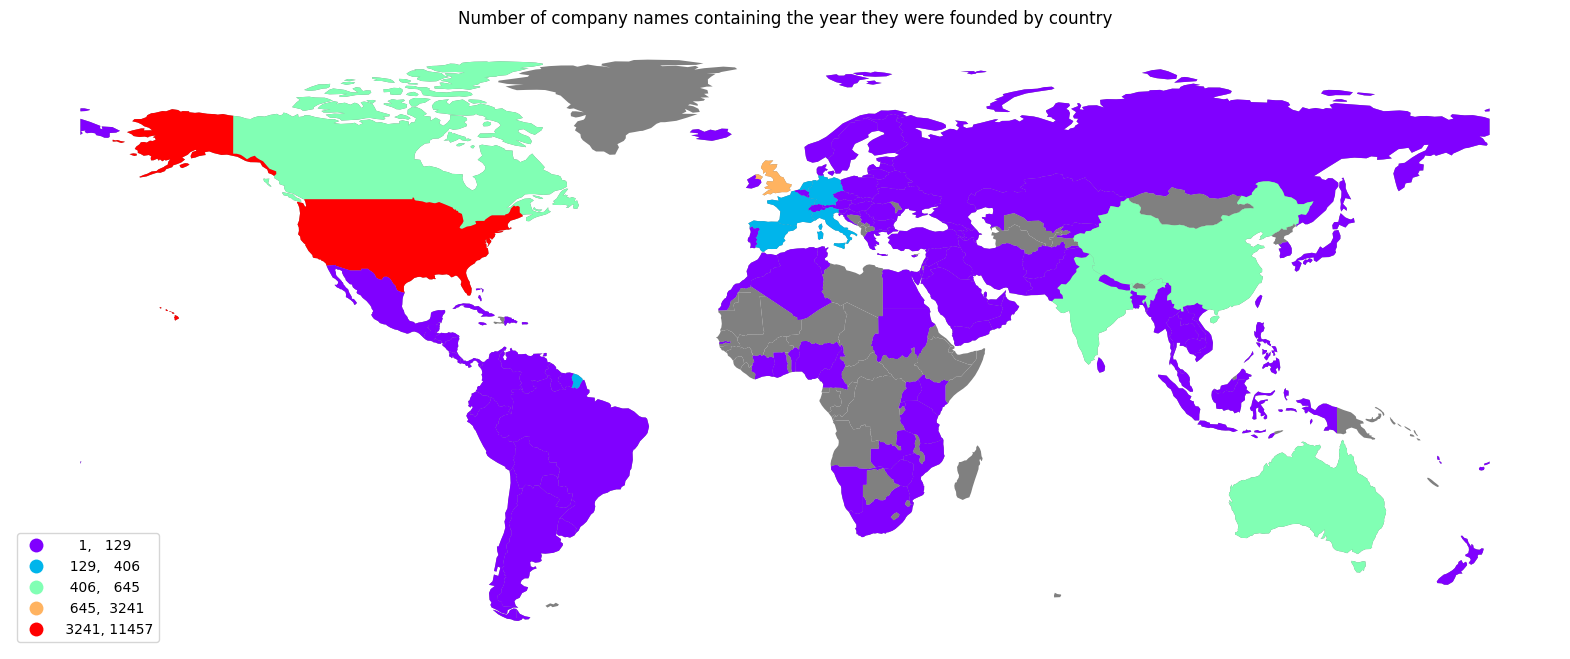

In [98]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Number of company names containing the year they were founded by country')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

#### year_in_name and size range

Let us check if these names are related to size range.

In [99]:
size_df = name_year_df.groupby('size range', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
size_counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='total_count')
size_df = size_df.merge(size_counts_df, left_on='size range', right_on='size range', how = 'left')
size_df =  size_df.sort_values(by='count',ascending=False).reset_index(drop=True)
size_df

size range  count  total_count
0        1 - 10  27756      5295776
1       11 - 50   4136      1126224
2      51 - 200   1041       324845
3     201 - 500    281        78494
4    501 - 1000    114        28394
5   1001 - 5000     86        24537
6  5001 - 10000     15         3044
7        10001+      4         2095

As we can see from the result above, if a company's name contains the year it was founded the company tends to have a small number of employees. Again this also aligns with the general distibution of size range. So I don't think there is a special connection here.

#### year_in_name and industry

Let us check if these names are related to which industry.

In [100]:
industry_df = name_year_df.groupby('industry', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
industry_counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='total_count')
industry_df = industry_df.merge(industry_counts_df, left_on='industry', right_on='industry', how = 'left')
industry_df =  industry_df.sort_values(by='count',ascending=False).reset_index(drop=True)
industry_df

industry  count  total_count
0          financial services  13549       170880
1                  accounting   1278        89203
2                   insurance   1191        70771
3                 real estate   1042       193486
4                construction    941       257921
..                        ...    ...          ...
143                   tobacco      6         1354
144              supermarkets      5         2859
145                  ranching      5         2324
146  package/freight delivery      4         3594
147        legislative office      1          524

[148 rows x 3 columns]

In [101]:
industry_df.head(10)

industry  count  total_count
0                   financial services  13549       170880
1                           accounting   1278        89203
2                            insurance   1191        70771
3                          real estate   1042       193486
4                         construction    941       257921
5                              banking    855        27617
6  information technology and services    775       453043
7                management consulting    583       194555
8                  facilities services    580        41317
9                investment management    532        32989

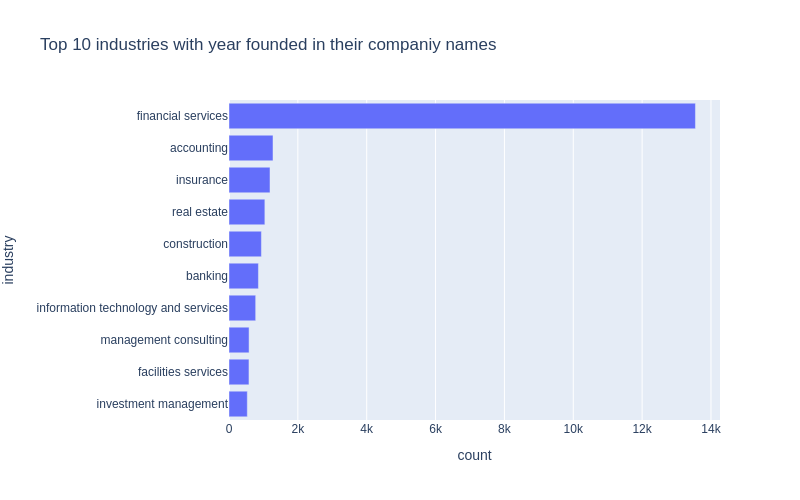

In [102]:
plotly_plot_bar(industry_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with year founded in their companiy names')

The bar chart plotted above shows top 10 industries with year founded in their companiy names. I think that it is obvious that sport companies are very associated with the year they were founded. The table above also proves this. Even though the sports industry has smaller number of companies in the dataset when compared to with the other industries ranking from 2-10, it is ranked as number 1 in the number of companiy names containing the year they were founded.

#### year_in_name and year founded

In [103]:
year_df = name_year_df.groupby('year founded', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
year_counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='total_count')
year_df = year_df.merge(year_counts_df, left_on='year founded', right_on='year founded', how = 'left')
year_df =  year_df.sort_values(by='count',ascending=False).reset_index(drop=True)
year_df['year founded'] = year_df['year founded'].astype('string')
year_df

Empty DataFrame
Columns: [count, year founded, total_count]
Index: []

In [104]:
year_df.head(10)

Empty DataFrame
Columns: [count, year founded, total_count]
Index: []

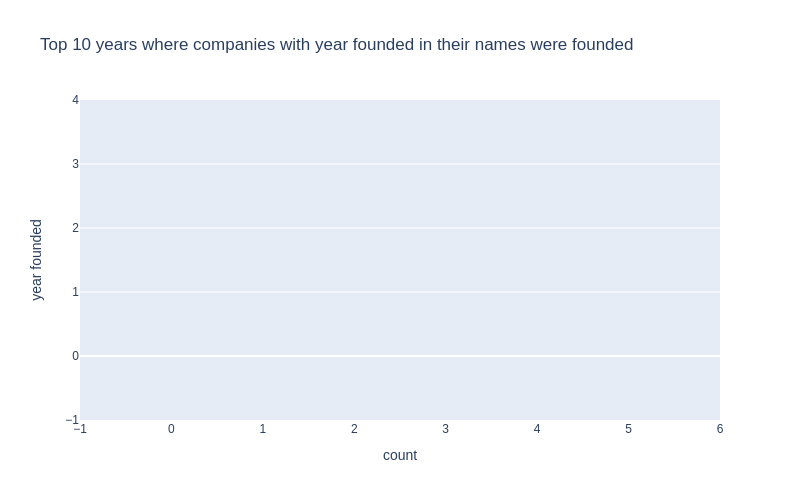

In [105]:
plotly_plot_bar(year_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='year founded', title='Top 10 years where companies with year founded in their names were founded')

Even though the number of companies founded in 2000 in the dataset are relatively smaller, it is ranked as number 1 in the number of company names containing the year they were founded. I think this is because the year 2000 is special as it is the start of a millenium, a year that comes once in a thousand years.

## Filtering Data and Answering Business Questions

### How many and which company names contain stop words?

In [106]:
def stopword_in_name(name):
    # split words in name and replace the & symbol with 'and'
    name_words = re.split(r'\s|-',re.sub('&', ' and ', name))
    return len([i for i in name_words if i in STOPWORDS])
df['stopword_in_name_count'] = df['name'].apply(stopword_in_name)

In [107]:
stopword_df = df[df['stopword_in_name_count'] > 0]
stopword_df

name             domain  year founded  \
9                                      at&t            att.com        1876.0   
16                          bank of america  bankofamerica.com        1968.0   
17                     jpmorgan chase & co.  jpmorganchase.com        1823.0   
38           department of veterans affairs             va.gov        1930.0   
59             american center of krasnodar                NaN           NaN   
...                                     ...                ...           ...   
7173390                 curl up & dye salon    curlupsalon.com           NaN   
7173397      stone center for yoga & health      stoneyoga.com           NaN   
7173411  fuller, hadeed, & ros-planas, pllc         fhrlaw.com        2015.0   
7173413       a w hargrove insurance agency                NaN           NaN   
7173423          catholic bishop of chicago                NaN           NaN   

                             industry size range  \
9                  telecommunications     10001+   
16                            banking     10001+   
17                 financial services     10001+   
38          government administration     10001+   
59               education management     10001+   
...                               ...        ...   
7173390                     cosmetics     1 - 10   
7173397  health, wellness and fitness     1 - 10   
7173411                  law practice     1 - 10   
7173413                     insurance     1 - 10   
7173423        religious institutions     1 - 10   

                                                locality        country  \
9                           dallas, texas, united states  united states   
16              charlotte, north carolina, united states  united states   
17                     new york, new york, united states  united states   
38       washington, district of columbia, united states  united states   
59                                                   NaN            NaN   
...                                                  ...            ...   
7173390                    hamilton, ohio, united states  united states   
7173397               teaneck, new jersey, united states  united states   
7173411          virginia beach, virginia, united states  united states   
7173413                  exmore, virginia, united states  united states   
7173423               inverness, illinois, united states  united states   

                                              linkedin url  \
9                                linkedin.com/company/at&t   
16                    linkedin.com/company/bank-of-america   
17                     linkedin.com/company/jpmorgan-chase   
38       linkedin.com/company/department-of-veterans-af...   
59       linkedin.com/company/american-center-of-krasnodar   
...                                                    ...   
7173390           linkedin.com/company/curl-up-&-dye-salon   
7173397  linkedin.com/company/stone-center-for-yoga-&-h...   
7173411                        linkedin.com/company/fhrlaw   
7173413  linkedin.com/company/a-w-hargrove-insurance-ag...   
7173423    linkedin.com/company/catholic-bishop-of-chicago   

         current employee estimate  total employee estimate  ...  \
9                           115188                   269659  ...   
16                           97357                   279769  ...   
17                           95234                   242135  ...   
38                           62685                    86489  ...   
59                           47345                    47924  ...   
...                            ...                      ...  ...   
7173390                          0                        1  ...   
7173397                          0                        2  ...   
7173411                          0                        2  ...   
7173413                          0                        1  ...   
7173423                          0                        1

There are more than 930,000 companies whose names contain atleast one stop word.

### How many and which company names contain punctuations?

In [108]:
punc_df = df[df['name_punc_count'] > 0]
punc_df

name              domain  year founded  \
5                           hewlett-packard             hpe.com        1939.0   
9                                      at&t             att.com        1876.0   
17                     jpmorgan chase & co.   jpmorganchase.com        1823.0   
30                   mcdonald's corporation  aboutmcdonalds.com        1955.0   
57         ayatama energi, trisco nusantara                 NaN        1999.0   
...                                     ...                 ...           ...   
7173397      stone center for yoga & health       stoneyoga.com           NaN   
7173402                      woonartikel.nl      woonartikel.nl        2015.0   
7173404                   squad sp. z o. o.        squad.com.pl        2013.0   
7173411  fuller, hadeed, & ros-planas, pllc          fhrlaw.com        2015.0   
7173416                     fit plus s.r.o.          fitplus.sk        1993.0   

                                    industry size range  \
5        information technology and services     10001+   
9                         telecommunications     10001+   
17                        financial services     10001+   
30                               restaurants     10001+   
57                                    design     10001+   
...                                      ...        ...   
7173397         health, wellness and fitness     1 - 10   
7173402                         online media     1 - 10   
7173404                             internet     1 - 10   
7173411                         law practice     1 - 10   
7173416         health, wellness and fitness     1 - 10   

                                        locality        country  \
5           palo alto, california, united states  united states   
9                   dallas, texas, united states  united states   
17             new york, new york, united states  united states   
30            oak brook, illinois, united states  united states   
57                                           NaN            NaN   
...                                          ...            ...   
7173397       teaneck, new jersey, united states  united states   
7173402       giethoorn, overijssel, netherlands    netherlands   
7173404           litzmannstadt, lodzkie, poland         poland   
7173411  virginia beach, virginia, united states  united states   
7173416       bratislava, bratislavský, slovakia       slovakia   

                                              linkedin url  \
5          linkedin.com/company/hewlett-packard-enterprise   
9                                linkedin.com/company/at&t   
17                     linkedin.com/company/jpmorgan-chase   
30             linkedin.com/company/mcdonald's-corporation   
57       linkedin.com/company/ayatama-energi-trisco-nus...   
...                                                    ...   
7173397  linkedin.com/company/stone-center-for-yoga-&-h...   
7173402                linkedin.com/company/woonartikel.nl   
7173404             linkedin.com/company/squad-sp.-z-o.-o.   
7173411                        linkedin.com/company/fhrlaw   
7173416               linkedin.com/company/fit-plus-s.r.o.   

         current employee estimate  total employee estimate  ...  \
5                           127952                   412952  ...   
9                           115188                   269659  ...   
17                           95234                   242135  ...   
30                           68233                   235199  ...   
57                           48806                    49370  ...   
...                            ...                      ...  ...   
7173397                          0                        2  ...   
7173402                          0                        1  ...   
7173404                          0                        1  ...   
7173411                          0                        2  ...   
7173416                          0                        1

There are more than 1,700,000 companies whose names contain atleast one punctuation mark.

### Which words are the most common in company names of each industry?

In [109]:
industries = list(df['industry'].unique())
industry_name_words_dict = {}
for industry in industries:
    industry_df = df[df['industry'] == f'{industry}']
    text = " ".join(name for name in industry_df.name)
    word_list = list(filter(lambda x: x!= '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    industry_name_words_dict[f'{industry}'] = common_words

In [110]:
def append_list(a,b):
    return a + b
all_words = reduce(append_list, list(industry_name_words_dict.values()))

In [111]:
# select common words found in atleast 20 industries
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 20]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [112]:
for (industry, words) in industry_name_words_dict.items():
    industry_name_words_dict[industry] = [word for word in words if word not in words_to_be_removed]

We can look at common words in company names from a specific industry as follows.

In [113]:
industry_name_words_dict['financial services']

['financial',
 'capital',
 'finance',
 'wealth',
 'mortgage',
 'partners',
 'credit',
 'advisors',
 'investment',
 'asset',
 'planning',
 'union',
 'group,',
 'advisory',
 'securities',
 'investments',
 'bank',
 'funding',
 'services,',
 'first',
 'llp',
 'insurance',
 'home',
 'management,']

In [114]:
def search_industry(word):
    industries_list = []
    for (industry, words) in industry_name_words_dict.items():
        if word in words:
            industries_list.append(industry)
    return industries_list

To search for a word if it is in the list of most common word for industries we can use the function search_industry as shown below.

In [115]:
search_industry('communication')

['telecommunications',
 'translation and localization',
 'wireless',
 'public relations and communications',
 'marketing and advertising',
 'graphic design']

### Which words are the most common in company names of each country?

In [116]:
countries = list(df['country'].unique())
country_name_words_dict = {}
for country in countries:
    country_df = df[df['country'] == f'{country}']
    text = " ".join(name for name in country_df.name)
    word_list = list(filter(lambda x: x!= '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    country_name_words_dict[f'{country}'] = common_words

In [117]:
all_words = reduce(append_list, list(country_name_words_dict.values()))

In [118]:
# select common words found in atleast 20 countries
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 20]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [119]:
for (country, words) in country_name_words_dict.items():
    country_name_words_dict[country] = [word for word in words if word not in words_to_be_removed]

We can look at common words in company names from a specific country as follows.

In [120]:
country_name_words_dict['netherlands']

['b.v.',
 'bv',
 'van',
 'nederland',
 'stichting',
 'advies',
 'voor',
 'groep',
 'amsterdam',
 'communicatie',
 'het',
 'advocaten',
 'europe',
 'der',
 'coaching',
 'online',
 'holland',
 'ict',
 'bureau',
 'benelux',
 'netherlands',
 'dutch']

In [121]:
def search_country(word):
    countries_list = []
    for (country, words) in country_name_words_dict.items():
        if word in words:
            countries_list.append(country)
    return countries_list

To search for a word if it is in the list of most common word for countries we can use the function search_country as shown below.

In [122]:
search_country('communication')

['france',
 'sweden',
 'switzerland',
 'algeria',
 'luxembourg',
 'morocco',
 'bangladesh',
 'tunisia',
 'senegal',
 'french polynesia',
 'albania',
 'benin',
 'democratic republic of the congo',
 'gabon',
 'u.s. virgin islands']

### Which words are the most common in company names of each size range?

In [123]:
size_ranges = list(df['size range'].unique())
size_range_name_words_dict = {}
for size_range in size_ranges:
    size_range_df = df[df['size range'] == f'{size_range}']
    text = " ".join(name for name in size_range_df.name)
    word_list = list(filter(lambda x: x!= '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    size_range_name_words_dict[f'{size_range}'] = common_words

In [124]:
all_words = reduce(append_list, list(size_range_name_words_dict.values()))

In [125]:
# select common words found in atleast 3 size ranges
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 2]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [126]:
for (size_range, words) in size_range_name_words_dict.items():
    size_range_name_words_dict[size_range] = [word for word in words if word not in words_to_be_removed]

Let's look at common words in company names for each size range.

In [127]:
size_range_name_words_dict

{'10001+': ['us',
  'american',
  'air',
  'education',
  'hotels',
  'financial',
  'system',
  'home',
  'life',
  'army',
  'united',
  'government',
  'communications',
  'china'],
 '5001 - 10000': ['financial',
  'life',
  'system',
  'banco',
  'energy',
  'plc',
  'industries',
  'universidade'],
 '1001 - 5000': ['la', 'council', 'trust', 'energy'],
 '501 - 1000': ['la', 'grupo'],
 '201 - 500': ['grupo'],
 '51 - 200': ['ab', 'hotel', 'spa', 'sa', 'software'],
 '11 - 50': ['srl',
  'design',
  'marketing',
  'capital',
  'associates',
  'partners',
  'ab',
  'association',
  'b.v.',
  'sa',
  'digital'],
 '1 - 10': ['design',
  'marketing',
  'studio',
  'co',
  'associates',
  'construction',
  'digital',
  'law',
  'capital',
  'pty',
  'srl',
  'creative',
  'service',
  'club']}

In [128]:
def search_size_range(word):
    size_ranges_list = []
    for (size_range, words) in size_range_name_words_dict.items():
        if word in words:
            size_ranges_list.append(size_range)
    return size_ranges_list

To search for a word if it is in the list of most common word for size_ranges we can use the function search_size_range as shown below.

In [129]:
search_size_range('hotel')

['51 - 200']

### Which words are the most common in company names founded during each decade after 1800?

In [130]:
df['decade'] = df['year founded'].apply(lambda x: f'{(x//10)*10}s')

Here we will considers companies with valid value for the column year founded.

In [133]:
from collections import Counter

decades = list(df['decade'].unique())

# Check if '0s' is in the list before removing it
if '0s' in decades:
    decades.remove('0s')

decade_name_words_dict = {}
for decade in decades:
    decade_df = df[df['decade'] == f'{decade}']
    words = " ".join(decade_df['name']).lower().split()
    decade_name_words_dict[decade] = Counter(words)

In [136]:
import re
import collections

# Your existing code here...

decades = list(df['decade'].unique())

# Check if '0s' is in the list before attempting to remove it
if '0s' in decades:
    decades.remove('0s')

decade_name_words_dict = {}
for decade in decades:
    decade_df = df[df['decade'] == f'{decade}']
    text = " ".join(name for name in decade_df.name)
    word_list = list(filter(lambda x: x != '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    decade_name_words_dict[f'{decade}'] = common_words


In [138]:
all_words = reduce(append_list, list(decade_name_words_dict.values()))

In [139]:
# select common words found in atleast 10 decades
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 10]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [140]:
for (decade, words) in decade_name_words_dict.items():
    decade_name_words_dict[decade] = [word for word in words if word not in words_to_be_removed]

We can look at common words in company names from a specific decade as follows.

In [147]:
decade_name_words_dict['2000.0s']

['solutions',
 'consulting',
 'design',
 'media',
 'management',
 'marketing',
 'technologies',
 'technology',
 'business',
 'e',
 'systems',
 'studio',
 'global',
 'pty',
 'digital',
 'capital',
 'srl',
 'creative',
 'partners',
 'software',
 'associates',
 'ab',
 'web',
 'pvt.',
 'communications',
 'law',
 'engineering',
 'co.,']

In [142]:
def search_decade(word):
    decades_list = []
    for (decade, words) in decade_name_words_dict.items():
        if word in words:
            decades_list.append(decade)
    return decades_list

To search for a word if it is in the list of most common word for decades we can use the function search_decade as shown below.

In [148]:
search_decade('software')

['1980.0s', '1990.0s', '2000.0s', '2010.0s']

## Conclusions of EDA

* The most common words are related to company structure like pvt, ltd, limited, llc, co, inc, group, and gmbh.
* Country and industry names are also frequent.
* Even though they are not frequent companies use single characters like s, b and v in their names. I assume that these characters are abbreviations and are mmostly followed by a peried(.).
* The most common industry is 'infomation technoogy and services'.
* More than 93% of the companies have employees less than or equal to 50.
* Most companies are found in the biggest cities of the developed world like london, new york, madrid and paris.
* On average chinese companies have many characters and words in their names when compared to other countries.
* On average the countries 'Czechia', 'Slovenia', 'Slovakia', 'China', 'Croatia', 'Venezuela', 'Thailand', 'Taiwan', and 'Bosnia And Herzegovina' have the highest number of punctuation marks in their company names.
* On average the countries 'Taiwan', 'Guadeloupe', 'South Korea', 'Venezuela', 'Albania', and 'Curaçao' have the highest number of digits in their company names.
* 'Belarus', 'Russia', 'Turkey', 'Iran', and 'Kazakhstan' are the countries with the highest number of non-aschii characters in their company names on average.
* 'United States', 'United Kingdom', 'Canada', 'India', and 'Australia' are top 5 countries with the highest number of companies with names containing atleast one word from their respective industry.
* 'marketing and advertising',  'management consulting', 'construction', 'hospital & health care', and 'information technology and services' are top 5 industries with the highest number of companies with names containing atleast one word from their respective industry.
* '2010', '2014', '2013', '2015', and '2012' are top 5 years  when with the highest number of companies with names containing atleast one word from their respective industry were founded.
* 'United States', 'India', 'Australia', 'Canada', and 'France' are top 5 countries with the highest number of companies with names containing atleast one word from their respective locality.
* 'information technology and services', 'non-profit organization management', 'education management', 'hospital & health care', and 'marketing and advertising' are top 5 industries with the highest number of companies with names containing atleast one word from their respective locality.
* '2012', '2014', '2013', '2015', and '2010' are top 5 years  when with the highest number of companies with names containing atleast one word from their respective locality were founded.
* 'sports',  'construction', 'information technology and services', 'marketing and advertising', and 'retail' are top 5 industries with the highest number of companies with names containing the year they were founded.
* '2000', '2010', '2016', '2014', and '2015' are top 5 years  when with the highest number of companies with names containing the year they were founded.